In [1]:
#//*** GEOPANDAS sources
#https://jcutrer.com/python/learn-geopandas-plotting-usmaps
#https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html
#https://towardsdatascience.com/lets-make-a-map-using-geopandas-pandas-and-matplotlib-to-make-a-chloropleth-map-dddc31c1983d
#https://geopandas.org/docs/user_guide/mapping.html

#//*** Build Custom Color Gradients
#https://coolors.co/gradient-palette/ffffff-e0472b?number=9

#//*** pandas_bokeh
#//*** https://pythonawesome.com/bokeh-plotting-backend-for-pandas-and-geopandas/

#//*** Clean geopandas install
#//***conda create -n geopandas -c conda-forge python=3.8 geopandas

Hospitalization research:
Data.gov search for tag: hhs-covid-19

posible lead: https://healthdata.gov/dataset/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/4cnb-m4rz

possible lead individual facility breakdown by week May - October 2021: https://healthdata.gov/dataset/COVID-19-Hospital-Data-Coverage-Report-v4wn-auj8-A/ewep-8fwa

This look like State Level Data: https://healthdata.gov/Hospital/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/g62h-syeh

Data CSV Link: https://healthdata.gov/api/views/g62h-syeh/rows.csv?accessType=DOWNLOAD

Healthdata.gov Hospitalization Search: https://healthdata.gov/browse?q=hospitalization&sortBy=relevance

Hospital Facility TimeSeries: https://healthdata.gov/Hospital/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/anag-cw7u


Other Sources:
 - COVID-19 State and County Policy Orders (infographic?): https://catalog.data.gov/dataset/covid-19-state-and-county-policy-orders-9408a

- [Graph: Infographic Visualization](#infographic_visualization)

<a id="top"></a> 
## Internal Links ##

- Working [working](#working).

- [Load/Rebuild County Level Combined Data Set: Vaccination, Cases, Deaths: rebuild county_daily_df](#rebuild_county_daily_df)

- [Load/Rebuild State Level Combined Data Set: Vaccination, Cases, Deaths: rebuild state_daily_df](#rebuild_state_daily_df)

- [ Build State Level: state_case_death_df - cases & deaths only ](#build_state_case_death_df)

- [ Load or Rebuild County Level Vaccine Data Set: county_vax_df](#rebuild_county_vax_df)

- [ Build Vaccine Tiers: County Data: county_tier_df](#build_tiers_county)

- [Build Vaccine Tiers: Statewide Data](#build_tiers_statewide)

- [ Build: hospital_df ](#build_hospital_df)

- [ Build: state_hosp_tiers_df](#state_hosp_tiers_df)

## Analyze ##
- [ Analyze State Hospitalization Tiers: state_hosp_tiers_df](#analyze_state_hosp_tiers_df)

## Graphs ##
- [ Blog Graphs ](#build_blog_graphs)

## HTML Processing ##


### CDC Community Transmission Guidelines

https://covid.cdc.gov/covid-data-tracker/#county-view



![](transmission_risk.png)

<a id="working"></a> 
# Working #

In [2]:
import os
import sys
# //*** Imports and Load Data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
#//*** Use the whole window in the IPYNB editor
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import time 
import random
from PIL import Image

import shutil
import json

import geopandas as gpd

import bokeh
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import DatetimeTickFormatter
from bokeh.embed import components
from bokeh.models import ColumnDataSource, Grid, HBar, LinearAxis, Plot

import pandas_bokeh
pandas_bokeh.output_notebook()

#https://docs.bokeh.org/en/latest/docs/reference/models/formatters.html
#https://docs.bokeh.org/en/latest/docs/user_guide/embed.html

#//*** Bokeh Categorical Labels
#https://docs.bokeh.org/en/0.12.10/docs/user_guide/categorical.html

#//*** Color Palettes: https://docs.bokeh.org/en/latest/docs/reference/palettes.html
#//*** Hover Tools: https://docs.bokeh.org/en/latest/docs/user_guide/tools.html
from datetime import datetime
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from scipy.stats.stats import pearsonr
from sklearn.linear_model import LinearRegression
import matplotlib

#//*** Maximize columns and rows displayed by pandas
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

pd.set_option('display.width', 200)

#//*** Holds 
out_plot = {}
out_stats = {}
out_images = []
out_exec_summary_images = []

med_figsize_x =634
med_figsize_y = 512

#df_list = []

#from sklearn import linear_model
#from math import sqrt
#from sklearn.metrics import mean_squared_error



Loading BokehJS ...

In [3]:
#"https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv"

#Hospitalizations - State
#https://www.cdc.gov/nhsn/covid19/report-patient-impact.html#anchor_1594393649
#DL: https://www.cdc.gov/nhsn/pdfs/covid19/covid19-NatEst.csv

# File Control #
 * use_cached_files = True - Use the Locally cached versions of the data
 * use_cached_files = False - Download updated source Data
 
 * rebuild_master_files = True - Rebuild county_daily_df. Takes 5-10 minutes
 * rebuild_master_files = False - Uses the cached version of the files

In [4]:
#//************************************************************************
#//*** If True, will rely on locally stored files
#//*** If False, will Download current data and rebuild all data sets
#//*** Should only be set to False if Data needs to be updated
#//************************************************************************
#use_cached_files = True
#rebuild_master_files = False

out_controls = {}
manage_df = {}

# Filepaths #

In [5]:
#//*** Raw Filenames
confirmed_data_filename = "z_us_confirmed.csv"
death_data_filename = "z_us_death_cases.csv"
vaccine_data_filename = "z_us_vaccination.csv"
county_vaccine_data_filename = "z_us_county_vaccination.csv.zip"
state_hospital_filename = "z_state_hospital.csv"

#//*** Filenames for Caching files locally
attrib_confirm_filename = "attrib_confirm_df.dat.zip"
attrib_death_filename =  "attrib_death_df.dat.zip"
all_dates_filename = "all_dates.json"
geo_vax_filename = "geo_vax_df.dat"
casevax_filename = "casevax.dat.zip"
county_daily_df_filename = "z_county_daily_df.csv.zip"
state_daily_df_filename = "z_state_daily_df.csv.zip"
hospital_df_filename = "z_hospital_df.csv.zip"

county_tier_df_filename = "z_county_tier_df.csv.zip"
whole_county_tier_df_filename = "z_whole_county_tier_df.csv.zip"

In [6]:
county_daily_df = pd.read_pickle(county_daily_df_filename)


<a id="rebuild_county_daily_df"></a> 
# Load or Rebuild County Level Combined Data Set: Cases & Deaths #

<a id="rebuild_county_vax_df"></a> 
# Load or Rebuild County Level Vaccine Data Set: county_vax_df #

In [7]:
#print("Loading Raw Vaccine Data")
#//*** read Raw Vaccine csv
county_vax_df = pd.read_pickle(county_vaccine_data_filename)

manage_df["county_vax_df"] = "County Vaccination Data [ 2020-12-13 - Present ]"

#//*** Filter Columns to get just the Completed Values
cols = ['Date','FIPS','Recip_County','Recip_State','Series_Complete_Pop_Pct','Series_Complete_Yes','Administered_Dose1_Pop_Pct','Administered_Dose1_Recip']


#//*** remove States not in continental US
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "AK" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "HI" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "AS" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "GU" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "MP" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "PR" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "VI" ]
county_vax_df = county_vax_df[county_vax_df["FIPS"] != "UNK" ]
county_vax_df['FIPS'] = county_vax_df['FIPS'].astype(int)
county_vax_df['Date'] = county_vax_df['Date'].apply(lambda x: datetime.strptime(x, "%m/%d/%Y").date())

county_vax_df = county_vax_df[cols]

#//*** Cleanup Column Names
ren_cols = {
'Administered_Dose1_Recip' : 'first_dose_count',
'Administered_Dose1_Pop_Pct' : 'first_dose_pct',
'Series_Complete_Yes' : 'total_vaccinated_count',
'Series_Complete_Pop_Pct' : 'total_vaccinated_percent',
}

cols = list(county_vax_df.columns)

for find,replace in ren_cols.items():
    cols = [replace if i==find else i for i in cols]

county_vax_df.columns=cols
    
county_vax_df

,Date,FIPS,Recip_County,Recip_State,total_vaccinated_percent,total_vaccinated_count,first_dose_pct,first_dose_count
0,2021-10-26,20021,Cherokee County,KS,41.0,8181,45.7,9111.0
1,2021-10-26,48151,Fisher County,TX,32.6,1248,37.8,1447.0
2,2021-10-26,53039,Klickitat County,WA,43.9,9852,47.2,10578.0
3,2021-10-26,12123,Taylor County,FL,35.4,7639,43.5,9391.0
4,2021-10-26,18095,Madison County,IN,47.7,61764,51.0,66140.0
...,...,...,...,...,...,...,...,...
1043680,2020-12-13,48093,Comanche County,TX,0.0,0,0.0,0.0
1043681,2020-12-13,36113,Warren County,NY,0.0,0,0.0,0.0
1043682,2020-12-13,35027,Lincoln County,NM,0.0,0,0.0,0.0
1043683,2020-12-13,18029,Dearborn County,IN,0.0,0,0.0,0.0


<a id="rebuild_state_daily_df"></a> 
# Load or Rebuild State Level Combined Data Set: Vaccination, Cases, Deaths #

In [8]:
state_daily_df = pd.read_pickle(state_daily_df_filename)
state_daily_df

manage_df['state_daily_df'] = "State Population Vaccination Case Death [2020-12-14 - Present]"

# Read all dates JSON
with open(all_dates_filename, "r") as infile:
    all_dates = json.loads(infile.read())['all_dates']

- [ go to Top](#top)
- [ Build State Level: state_case_death_df - cases & deaths only ](#build_state_case_death_df)
<a id="build_state_case_death_df"></a> 
# Build State Level: state_case_death_df - cases & deaths only #




In [9]:
#//**************************************************************************************************
#//**** Build Just Cases and Deaths at State Level. These will integrate with Hospitalizations
#//**** Orginally geo_vax_df...Now: state_daily_df
#//**************************************************************************************************

manage_df['confirm_df'] = "Johns Hopkins Case Data stored in Date Columns [20/01/22 - Present]"
manage_df['death_df'] = "Johns Hopkins Death Data stored in Date Columns [20/01/22 - Present]"
#//**** Load Confirmed Data
confirm_df = pd.read_csv(confirmed_data_filename)
confirm_df = confirm_df.dropna(subset=["FIPS"])

#//**** Load death Data
death_df = pd.read_csv(death_data_filename)
death_df = death_df[death_df["Admin2"] != "Unassigned"]
death_df = death_df.dropna(subset=["FIPS"])

#//**** Load raw Vax Data
vax_df = pd.read_csv(vaccine_data_filename)

#//*** Filter Columns to get just the Completed Values
cols = ['Date','Location']
filter_val = ['FedLTC','Unk','Janssen','Pfizer','Moderna','Fed_LTC']
for col in vax_df.columns:
    if 'Complete' in col or 'Dose1' in col:
        skipVal = False
        for val in filter_val:
            if val in col:
                skipVal = True
                continue
        if skipVal:
            continue
        cols.append(col)


#//***************************************
#//*** Build Vaccine Geographic Data
#//***************************************

#//*** Get Shape File
state_case_death_df = gpd.read_file('maps\cb_2018_us_state_20m.shp')

#//*** Keep the important Columns
state_case_death_df = state_case_death_df[['STATEFP','GEOID','NAME','geometry']]

state_case_death_df['GEOID'] = state_case_death_df['GEOID'].astype(int)
state_case_death_df['STATEFP'] = state_case_death_df['STATEFP'].astype(int)



#//*** Vaccine Info only has State Abbreviations. Need to add FIPS codes to merge with geographic data
#//*** Load DF with States and FIPS values
#state_fips = pd.read_csv("state_fips.csv")
#geo_vax_df = state_fips.merge(vax_df,left_on="Postal Code",right_on="Location")

#//*** remove States not in continental US
state_case_death_df = state_case_death_df[state_case_death_df["NAME"] != "Alaska" ]
state_case_death_df = state_case_death_df[state_case_death_df["NAME"] != "Hawaii" ]
state_case_death_df = state_case_death_df[state_case_death_df["NAME"] != "Puerto Rico" ]
state_case_death_df = state_case_death_df[state_case_death_df["NAME"] != "District of Columbia" ]

#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "HI" ]
#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "AS" ]
#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "GU" ]
#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "MP" ]
#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "PR" ]
#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "VI" ]



#geo_vax_df['Date'] = geo_vax_df['Date'].apply(lambda x: datetime.strptime(x, "%m/%d/%Y"))

state_case_death_df = state_case_death_df.sort_values('NAME').reset_index()

#//*** Extract Deaths and Confirmed Cases From JOhns Hopkins Column wise data and merge with Vaccine Row Data

#//***Process Deaths
us_deaths_df = pd.DataFrame()

for group in death_df.groupby('Province_State'):
    loop_stats_df = group[1][group[1].columns[12:]]
    #print(loop_stats_df.columns)

    base_row = pd.Series([group[0],group[1]['Population'].sum()], index=['state','population'])

    base_row = pd.DataFrame(base_row).transpose()
    stats_df = pd.DataFrame([[group[0]],loop_stats_df.sum().index,loop_stats_df.sum()]).transpose()
    stats_df.columns = ['state','Date','tot_death']
    stats_df['state'] = stats_df['state'].fillna(group[0])
    base_row = base_row.merge(stats_df,left_on="state",right_on="state")
    us_deaths_df = pd.concat([us_deaths_df,base_row])

#print(us_deaths_df)

us_df = pd.DataFrame()
#//***Process confirmed and merge with deaths
for group in confirm_df.groupby('Province_State'):
    loop_stats_df = group[1][group[1].columns[11:]]
    #print(loop_stats_df.columns)
    stats_df = pd.DataFrame([loop_stats_df.sum().index,loop_stats_df.sum()]).transpose()
    stats_df.columns = ['Date','tot_confirm']

    us_df = pd.concat([us_df,us_deaths_df[us_deaths_df['state']==group[0]].merge(stats_df,left_on='Date',right_on='Date')])


us_df['Date'] = us_df['Date'].apply(lambda x: datetime.strptime(x, "%m/%d/%y"))  
us_df = us_df.reset_index(drop='True')

for col in ['New_Cases','New_Deaths']:
    us_df[col] = np.nan



#//*** Drops Diamon Princess, Virgin Islands, and anything not listed as a state in the continental united states
state_case_death_df = state_case_death_df.merge(us_df, left_on='NAME', right_on='state')
tdf = pd.DataFrame()

for group in state_case_death_df.groupby('state'):
    loop_df = group[1].copy()
    
    
    
    loop_df['New_Cases'] = loop_df['tot_confirm'].copy().diff(2)

    #//*** Replace Values that Are less than zero with Zero.
    loop_df.loc[loop_df['New_Cases'] < 0,f'New_Cases']=0

    loop_df['case_7_day_avg'] = loop_df['New_Cases'].rolling(7).mean()
    loop_df['case_avg_100k'] = loop_df['New_Cases'] / (loop_df['population'] / 100000)
    loop_df['New_Deaths'] = loop_df['tot_death'].copy().diff(2)

            #//*** Replace Values that Are less than zero with Zero.
    loop_df.loc[loop_df['New_Deaths'] < 0,f'New_Deaths']=0
    loop_df['death_7_day_avg'] = loop_df['New_Deaths'].rolling(7).mean()
    loop_df['death_avg_100k'] = loop_df['New_Deaths'] / (loop_df['population'] / 100000)
    
    loop_df = loop_df.dropna()
    
    loop_df['loc'] = (state_daily_df[state_daily_df['GEOID'] == loop_df['GEOID'].iloc[0]])['Location'].iloc[0]
    
    #print((state_daily_df[state_daily_df['GEOID'] == loop_df['GEOID'].iloc[0]])['Location'].iloc[0])
    #print(loop_df)
    tdf = pd.concat([tdf,loop_df])
state_case_death_df = tdf
del tdf
del us_df
del us_deaths_df

state_case_death_df = state_case_death_df.sort_values(['Date','NAME'])
state_case_death_df

manage_df['state_case_death'] = "State Level Cases and Deaths Only [2020/01/30 - Present]"
#print(state_case_death_df)

<a id="rebuild_column_data_for_bokeh"></a> 
# Load or Rebuild Columwise Dataframes for Bokeh Slider Plots: attrib_confirm_df, attrib_death_df #

In [10]:
attrib_confirm_df = pd.read_pickle(attrib_confirm_filename)
manage_df['attrib_confirm_df'] = "Case Data stored Column Wise for Bokeh Slider plots includes New Cases, Cases 100k, Scaled Cases, [2020/01/29 - Present]"
attrib_death_df = pd.read_pickle(attrib_death_filename)
manage_df['attrib_death_df'] = "Death Data stored Column Wise for Bokeh Slider plots includes New Deaths, Deaths 100k, Scaled Cases, [2020/01/29 - Present]"
#print("Loading Cached: death_df")

- [ go to Top](#top)
- [ Build: hospital_df](#build_hospital_df)
<a id="build_hospital_df"></a> 
# Build: hospital_df #


In [11]:
#//*** Raw data description
#https://healthdata.gov/Hospital/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/g62h-syeh
#//*** There are 116 Columns. Gotta Pair it down
manage_df['hospital_df'] = "Statewide Hospitalization Numbers [2020-01-01 - Present]"
hospital_df = pd.read_csv(state_hospital_filename)
hospital_df

#//*** Remove columns that include these words
exclude_cols = ['coverage','numerator','denominator','previous','influenza','geocoded_state','total_pediatric_patients_hospitalized_confirmed_covid','critical_staffing_shortage_today_not_reported','anticipated','staffed_icu_adult_patients_confirmed_covid','total_adult_patients_hospitalized_confirmed_covid','critical_staffing_shortage_today_no','deaths_covid']

cols = []

for col in hospital_df.columns:
    for frag in exclude_cols:
        if frag in col:
            del hospital_df[col]
            break
            
            
#//*** rename columns for redability            
ren_cols = {
    'critical_staffing_shortage_today_yes' : "short_staffed",
    'hospital_onset_covid' : 'got_covid_at_hosp',
    'inpatient_beds' : 'total_beds',
    'inpatient_beds_used' : "beds_used",
    'inpatient_beds_used_covid' : 'covid_beds_used',
    'staffed_adult_icu_bed_occupancy' : "icu_occupancy",
    'staffed_icu_adult_patients_confirmed_and_suspected_covid' : 'covid_icu',
    'total_adult_patients_hospitalized_confirmed_and_suspected_covid' : 'covid_beds_adult',
    'total_pediatric_patients_hospitalized_confirmed_and_suspected_covid' : 'covid_beds_kids',
    'total_staffed_adult_icu_beds' : 'icu_total',
    'inpatient_beds_utilization' : 'beds_used_pct',
    'percent_of_inpatients_with_covid' : 'covid_patients_pct',
    'inpatient_bed_covid_utilization' : 'covid_beds_pct',
    'adult_icu_bed_covid_utilization' : 'icu_used',
    'adult_icu_bed_utilization' : 'icu_used_pct',
    'on_hand_supply_therapeutic_a_casirivimab_imdevimab_courses' : 'therapy_a',
    'on_hand_supply_therapeutic_b_bamlanivimab_courses' : 'therapy_b',
    'on_hand_supply_therapeutic_c_bamlanivimab_etesevimab_courses' : 'therapy_b',
    'date' : 'Date',
}

#//*** Rename Columns for readability
cols = hospital_df.columns
for find_col,replace_col in ren_cols.items():
    if find_col in cols:
        cols = np.where(cols == find_col,replace_col,cols)

hospital_df.columns = cols

#//*** Convert everything to floats where possible
for col in hospital_df.columns:
    try:
        hospital_df[col] = hospital_df[col].astype(float)
    except:
        continue
        
hospital_df['Date'] = hospital_df['Date'].apply(lambda x: datetime.strptime(x, "%Y/%m/%d").date())
        
hospital_df = hospital_df.sort_values('Date')

hospital_df

,state,Date,short_staffed,got_covid_at_hosp,total_beds,beds_used,covid_beds_used,icu_occupancy,covid_icu,covid_beds_adult,covid_beds_kids,icu_total,beds_used_pct,covid_patients_pct,covid_beds_pct,icu_used,icu_used_pct,therapy_a,therapy_b,therapy_b
29071,IN,2020-01-01,0.0,0.0,30.0,15.0,0.0,NaN,NaN,NaN,NaN,NaN,0.500000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
28355,MT,2020-01-01,0.0,0.0,36.0,12.0,0.0,NaN,NaN,NaN,NaN,NaN,0.333333,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
32110,AL,2020-01-01,0.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30492,NC,2020-01-01,0.0,0.0,72.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25295,MN,2020-01-01,0.0,0.0,46.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24447,SC,2021-10-26,29.0,7.0,10425.0,8016.0,750.0,960.0,217.0,741.0,9.0,1327.0,0.768921,0.094733,0.073099,0.168609,0.723436,4407.0,3209.0,2433.0
21484,UT,2021-10-26,1.0,1.0,5529.0,3388.0,527.0,454.0,191.0,517.0,10.0,622.0,0.612769,0.157832,0.096662,0.312092,0.729904,592.0,268.0,97.0
12767,OH,2021-10-26,33.0,38.0,28185.0,21075.0,3026.0,2945.0,791.0,2839.0,187.0,3899.0,0.747738,0.144875,0.108544,0.206312,0.755322,992.0,925.0,702.0
12420,NE,2021-10-26,19.0,5.0,3875.0,2933.0,401.0,399.0,122.0,392.0,9.0,473.0,0.757490,0.138850,0.104946,0.264642,0.843552,1334.0,558.0,572.0


<a id="build_tiers_statewide"></a> 
# Build Vaccine Tiers: Statewide Data #

In [12]:
#//*** Build State Tiers By Vaccinated Percent

plot_df = state_daily_df

print()
plot_df = plot_df[plot_df['Date'] > plot_df['Date'].unique()[0]]
print(plot_df[plot_df['Date'] == plot_df['Date'].max()]['total_vaccinated_percent'].min())
print(plot_df[plot_df['Date'] == plot_df['Date'].max()]['total_vaccinated_percent'].max())


#//*** Build Sorted list of States by Vaccination
#cats = list(plot_df[plot_df['Date'] == plot_df['Date'].min()].sort_values('death_7_day_avg',ascending=False)['state'])
#cats

plot_dict = {}

#//*** Values for Each Category

#//*** Category is the State Name
#category_col = 'Name'
vax_range_dict = {}
vax_range_dict['40'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] < 45) ]['Name'])
vax_range_dict['45'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] >= 45) & (plot_df['total_vaccinated_percent'] < 50)]['Name'])
vax_range_dict['50'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] >= 50) & (plot_df['total_vaccinated_percent'] < 55)]['Name'])
vax_range_dict['55'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] >= 55) & (plot_df['total_vaccinated_percent'] < 60)]['Name'])
vax_range_dict['60'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] >= 60) & (plot_df['total_vaccinated_percent'] < 65)]['Name'])
vax_range_dict['65'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] >= 65) ]['Name'])


vax_tier_state_df = pd.DataFrame()

cols = ['Date','tier','population','total_vaccinated_count','first_dose_count','tot_confirm','tot_death','New_Cases','New_Deaths']





for index in ['40','45','50','55','60','65']:

    tier_df = pd.DataFrame()

    #//*** Get DF that contains list of States. Loop through those tiers and combine them
    for group in plot_df[plot_df['Name'].str.contains('|'.join(vax_range_dict[index]))].groupby('Date'):

        loop_list = [group[0],f'total_{index}']
        for col in cols[2:]:
            loop_list.append(group[1][col].astype(int).sum())

        loop_df = pd.DataFrame(loop_list).transpose()
        loop_df.columns = cols

        for col in cols[2:]:
            loop_df[col] = loop_df[col].astype(int)
            
        tier_df = pd.concat([tier_df, loop_df])
        #print(loop_df)

    tier_df['case_7_day_avg'] = tier_df['New_Cases'].rolling(14).mean()
    tier_df['death_7_day_avg'] = tier_df['New_Deaths'].rolling(14).mean()

    tier_df['case_avg_100k'] = tier_df['case_7_day_avg'] / (tier_df['population'] / 100000) 
    tier_df['death_avg_100k'] = tier_df['death_7_day_avg'] / (tier_df['population'] / 100000) 
    
    tier_df['total_vaccinated_percent'] = tier_df['total_vaccinated_count'] / tier_df['population']
    tier_df['first_dose_pct'] = tier_df['first_dose_count'] / tier_df['population']
    
    vax_tier_state_df = pd.concat([vax_tier_state_df,tier_df])

vax_tier_state_df.dropna(inplace=True)
vax_tier_state_df = vax_tier_state_df.reset_index()
#print(vax_tier_state_df)

#//*** Build Sorted list of States by Vaccination
cats = list(vax_tier_state_df['tier'].unique())
cats
manage_df['vax_tier_state_df'] = "State Tiers: Vaccinated, Confirm, Deaths [2020-12-28 - Present]"
vax_tier_state_df[vax_tier_state_df['tier'] == 'total_40'].reset_index()


41.0
70.9


,level_0,index,Date,tier,population,total_vaccinated_count,first_dose_count,tot_confirm,tot_death,New_Cases,New_Deaths,case_7_day_avg,death_7_day_avg,case_avg_100k,death_avg_100k,total_vaccinated_percent,first_dose_pct
0,0,0,2020-12-28,total_40,9061156,0,0,610047,7757,7479,92,12295.142857,162.000000,135.690665,1.787851,0.000000,0.000000
1,1,0,2020-12-29,total_40,9061156,0,0,617024,7819,11271,147,12247.571429,164.500000,135.165661,1.815442,0.000000,0.000000
2,2,0,2020-12-30,total_40,9061156,0,0,625042,7900,14995,143,12320.785714,160.357143,135.973663,1.769721,0.000000,0.000000
3,3,0,2020-12-31,total_40,9061156,0,0,632046,8039,15022,220,12324.714286,157.714286,136.017019,1.740554,0.000000,0.000000
4,4,0,2021-01-01,total_40,9061156,0,0,639053,8107,14011,207,12128.357143,157.000000,133.849998,1.732671,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,297,0,2021-10-21,total_40,9061156,3918938,4665633,1463516,24084,7814,224,7035.500000,208.428571,77.644618,2.300243,0.432499,0.514905
298,298,0,2021-10-22,total_40,9061156,3927571,4675769,1468110,24193,8742,181,6979.357143,198.714286,77.025019,2.193035,0.433451,0.516023
299,299,0,2021-10-23,total_40,9061156,3935199,4682225,1470653,24231,7137,147,6938.071429,187.142857,76.569385,2.065331,0.434293,0.516736
300,300,0,2021-10-24,total_40,9061156,3938710,4685406,1471951,24232,3841,39,6862.000000,182.285714,75.729852,2.011727,0.434681,0.517087


- [ go to Top](#top)
- [ Build: state_hosp_tiers_df](#state_hosp_tiers_df)

<a id="state_hosp_tiers_df"></a> 
# Build: state_hosp_tiers_df #

In [13]:
working_df = state_daily_df[state_daily_df['Date'] == state_daily_df['Date'].max()]



hosp_tier_dict = {}
#//*** Group FIPS by Total vaccinated Percent
#//*** Put Results in Dictionary
for i in range(20):
    low_i = i * 5
    high_i = low_i+5
    loop_df = working_df[ (working_df['total_vaccinated_percent'] >= low_i) & (working_df['total_vaccinated_percent'] < high_i) ]
    if len(loop_df) > 0:
        
        hosp_tier_dict[low_i] = {'FIPS' : list(loop_df['FIPS'].astype(int).unique()), 'state' : list(loop_df['Postal Code'].unique())}
print(hosp_tier_dict)


state_hosp_tiers_df = pd.DataFrame()

hosp_cols = ['total_beds','beds_used','covid_beds_used','icu_total','icu_used','covid_icu','covid_beds_adult','covid_beds_kids']

sum_cols_state = ['population','tot_confirm','tot_death']

working_df = state_case_death_df

#//*** Get DF that contains list of States. Loop through those tiers and combine them
for tier,loop_dict in hosp_tier_dict.items():
    FIPS_list = loop_dict['FIPS']
    state_list = loop_dict['state']
    date_df = pd.DataFrame()
    print(tier)
    for group in working_df[working_df['GEOID'].isin(FIPS_list)].groupby('Date'):
        
        #print(hospital_df[hospital_df['Date'] == group[0]])
        
        #//*** Get the first row, this will hold all the columns and attributes
        out_df = group[1].iloc[0].copy()
        
        
        #//*** Sum appropriate columns for aggregation
        for col in sum_cols_state:
            
            val = group[1][col].sum()
                
            out_df[col] = val

        #//*** Keep a list of all FIPS values in tier, just in case
        out_df['FIPS'] = FIPS_list

        out_df['tier'] = f"total_{tier}"
        
        
        #//*** Get Hospital values for given states on given day
        thosp = hospital_df[hospital_df['state'].isin(state_list)]
        thosp = thosp[thosp['Date']==group[0]]
        
        #print(thosp)
        #print(thosp['total_beds'].sum())
        #//*** Sum the hospital columns
        for col in hosp_cols:
            out_df[col] = np.array(thosp[col].sum())
            #print(col," - ",np.array(thosp[col].sum()) )
            
            

        
        #print(out_df)
        #//*** Add this single row based on date
        date_df = pd.concat([date_df,pd.DataFrame(out_df).transpose()])
        

        date_df['New_Cases'] = date_df['tot_confirm'].diff(2)
        date_df['New_Deaths'] = date_df['tot_death'].diff(2)

        #//*** Reset Negative Confirmed to 0
        date_df.loc[date_df['New_Cases'] < 0,f'New_Cases']=0

        #//*** Reset Negative Deaths to 0
        date_df.loc[date_df['New_Deaths'] < 0,f'New_Deaths']=0

        date_df['case_7_day_avg'] = date_df['New_Cases'].rolling(7).mean()
        date_df['death_7_day_avg'] = date_df['New_Deaths'].rolling(7).mean()

        date_df['case_avg_100k'] = date_df['case_7_day_avg'] / (date_df['population'] / 100000 )
        date_df['death_avg_100k'] = date_df['death_7_day_avg'] / (date_df['population'] / 100000 )

        #//*** Cap 100k values at 100 & 5 for plotting
        date_df['case_scaled_100k'] = date_df['case_avg_100k']
        date_df['death_scaled_100k'] = date_df['death_avg_100k']

        date_df.loc[date_df[f"case_scaled_100k"] > 100,f"case_scaled_100k"]=100
        date_df.loc[date_df[f"death_scaled_100k"] > 5,f"death_scaled_100k"]=5
        
        


        #print( hospital_df[hospital_df['Date'] == group[0]] )

        #date_df['total_vaccinated_percent'] = ((date_df['total_vaccinated_count'] / date_df['population']) * 100)
        #date_df['first_dose_pct'] = ((date_df['first_dose_count'] / date_df['population']) * 100)
    
    
    date_df = date_df.dropna(subset=['case_avg_100k'])
    state_hosp_tiers_df = pd.concat([state_hosp_tiers_df,date_df])
    #print(state_hosp_tiers_df)
print("Done!")

#//*** Cleanup the shape columns. those are not needed here
for col in ['index','STATEFP','GEOID','NAME','geometry','state']:
    if col in state_hosp_tiers_df.columns:
        del state_hosp_tiers_df[col]
manage_df['state_hospital_tiers_df'] = "Tiers Statewide Hospitalization Case and Death [2020-02-07 - Present]"
state_hosp_tiers_df

{40: {'FIPS': [1, 16, 54, 56], 'state': ['AL', 'ID', 'WV', 'WY']}, 45: {'FIPS': [5, 13, 18, 22, 28, 29, 38, 40, 45, 47], 'state': ['AR', 'GA', 'IN', 'LA', 'MS', 'MO', 'ND', 'OK', 'SC', 'TN']}, 50: {'FIPS': [4, 17, 20, 21, 26, 30, 32, 37, 39, 46, 48, 49], 'state': ['AZ', 'IL', 'KS', 'KY', 'MI', 'MT', 'NV', 'NC', 'OH', 'SD', 'TX', 'UT']}, 55: {'FIPS': [10, 12, 19, 27, 31, 55], 'state': ['DE', 'FL', 'IA', 'MN', 'NE', 'WI']}, 60: {'FIPS': [6, 8, 33, 41, 42, 51, 53], 'state': ['CA', 'CO', 'NH', 'OR', 'PA', 'VA', 'WA']}, 65: {'FIPS': [24, 25, 34, 35, 36], 'state': ['MD', 'MA', 'NJ', 'NM', 'NY']}, 70: {'FIPS': [9, 23, 44, 50], 'state': ['CT', 'ME', 'RI', 'VT']}}
40
45
50
55
60
65
70
Done!


,population,Date,tot_death,tot_confirm,New_Cases,New_Deaths,case_7_day_avg,case_avg_100k,death_7_day_avg,death_avg_100k,loc,FIPS,tier,total_beds,beds_used,covid_beds_used,icu_total,icu_used,covid_icu,covid_beds_adult,covid_beds_kids,case_scaled_100k,death_scaled_100k
16,9061156,2020-02-07,0,0,0,0,0.000000,0.0,0.000000,0.0,AL,"[1, 16, 54, 56]",total_40,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,9061156,2020-02-08,0,0,0,0,0.000000,0.0,0.000000,0.0,AL,"[1, 16, 54, 56]",total_40,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,9061156,2020-02-09,0,0,0,0,0.000000,0.0,0.000000,0.0,AL,"[1, 16, 54, 56]",total_40,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,9061156,2020-02-10,0,0,0,0,0.000000,0.0,0.000000,0.0,AL,"[1, 16, 54, 56]",total_40,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,9061156,2020-02-11,0,0,0,0,0.000000,0.0,0.000000,0.0,AL,"[1, 16, 54, 56]",total_40,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3853,6592849,2021-10-21,13026,715474,2957,20,2832.000000,42.955633,16.142857,0.244854,CT,"[9, 23, 44, 50]",total_70,15434.0,12528.0,606.0,1621.0,0.572948753948006,181.0,596.0,10.0,42.955633,0.244854
3854,6592849,2021-10-22,13050,716926,3031,30,2728.142857,41.380333,16.428571,0.249188,CT,"[9, 23, 44, 50]",total_70,15504.0,12529.0,617.0,1628.0,0.473183777364258,158.0,607.0,10.0,41.380333,0.249188
3855,6592849,2021-10-23,13057,717764,2290,31,2703.857143,41.011968,17.571429,0.266523,CT,"[9, 23, 44, 50]",total_70,15449.0,12132.0,605.0,1617.0,0.5273319485611321,166.0,594.0,11.0,41.011968,0.266523
3856,6592849,2021-10-24,13057,718034,1108,7,2700.714286,40.964298,18.000000,0.273023,CT,"[9, 23, 44, 50]",total_70,15346.0,11835.0,610.0,1627.0,0.511349017897782,174.0,599.0,11.0,40.964298,0.273023


<a id="build_tiers_county"></a> 
# Build Vaccine Tiers: County Data: county_tier_df #

In [14]:
print("Loading Cached County Tier Data")
county_tier_df = pd.read_pickle(county_tier_df_filename)
manage_df['county_tier_df'] = "Tiers County Vaccinations Cases Deaths[2020-12-21 - Present]"
county_tier_df

Loading Cached County Tier Data


,Date,FIPS,Admin2,Province_State,Combined_Key,Population,tot_confirm,tot_deaths,New_Confirm,New_Deaths,case_7_day_avg,death_7_day_avg,case_100k_avg,death_100k_avg,case_scaled_100k,death_scaled_100k,total_vaccinated_percent,total_vaccinated_count,first_dose_pct,first_dose_count,tier
334,2020-12-21,"[8109, 48241, 1117, 40129, 32027, 21203, 47153...",Bibb,Alabama,"Bibb, Alabama, US",19511025,1095291,18518,17688,116,24665.428571,304.571429,126.417903,1.561022,100,1.561022,0.0,0,0.0,0.0,total_30
335,2020-12-22,"[8109, 48241, 1117, 40129, 32027, 21203, 47153...",Bibb,Alabama,"Bibb, Alabama, US",19511025,1110084,18739,22452,271,24784.000000,304.571429,127.025618,1.561022,100,1.561022,0.0,0,0.0,0.0,total_30
336,2020-12-23,"[8109, 48241, 1117, 40129, 32027, 21203, 47153...",Bibb,Alabama,"Bibb, Alabama, US",19511025,1123774,18966,28483,448,24938.000000,309.714286,127.814915,1.587381,100,1.587381,0.0,0,0.0,0.0,total_30
337,2020-12-24,"[8109, 48241, 1117, 40129, 32027, 21203, 47153...",Bibb,Alabama,"Bibb, Alabama, US",19511025,1139086,19159,29002,420,25068.285714,309.000000,128.482669,1.58372,100,1.58372,0.0,0,0.0,0.0,total_30
338,2020-12-25,"[8109, 48241, 1117, 40129, 32027, 21203, 47153...",Bibb,Alabama,"Bibb, Alabama, US",19511025,1147403,19269,23629,303,24160.428571,302.285714,123.829622,1.549307,100,1.549307,0.0,0,0.0,0.0,total_30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
638,2021-10-21,"[6013, 48479, 36059, 6001, 30035, 55007, 53055...",Apache,Arizona,"Apache, Arizona, US",25211041,2869998,47317,6809,89,6829.428571,82.142857,27.089038,0.325821,27.089038,0.325821,72.130611,18184878,80.390496,20267281.0,total_70
639,2021-10-22,"[6013, 48479, 36059, 6001, 30035, 55007, 53055...",Apache,Arizona,"Apache, Arizona, US",25211041,2875075,47362,8513,86,6610.714286,83.857143,26.221505,0.332621,26.221505,0.332621,73.078105,18423751,81.552694,20560283.0,total_70
640,2021-10-23,"[6013, 48479, 36059, 6001, 30035, 55007, 53055...",Apache,Arizona,"Apache, Arizona, US",25211041,2876307,47370,6309,53,6440.857143,87.857143,25.547764,0.348487,25.547764,0.348487,73.150173,18441920,81.633376,20580624.0,total_70
641,2021-10-24,"[6013, 48479, 36059, 6001, 30035, 55007, 53055...",Apache,Arizona,"Apache, Arizona, US",25211041,2876862,47373,1787,11,6424.142857,84.428571,25.481466,0.334887,25.481466,0.334887,73.20424,18455551,81.691994,20595402.0,total_70


In [15]:
print("Loading Cached Whole County Tier Data")
whole_county_tier_df = pd.read_pickle(whole_county_tier_df_filename)
manage_df['whole_county_tier_df'] = ["tier county cases and deaths [2020-02-06 - Present]"]
whole_county_tier_df

Loading Cached Whole County Tier Data


,Date,FIPS,Admin2,Province_State,Combined_Key,Population,tot_confirm,tot_deaths,New_Confirm,New_Deaths,case_7_day_avg,death_7_day_avg,case_100k_avg,death_100k_avg,case_scaled_100k,death_scaled_100k,tier
15,2020-02-06,"[8109, 48241, 1117, 40129, 32027, 21203, 47153...",Bibb,Alabama,"Bibb, Alabama, US",19511025,0,0,0,0,0.000000,0.000000,0.0,0.0,0.0,0.0,total_30
16,2020-02-07,"[8109, 48241, 1117, 40129, 32027, 21203, 47153...",Bibb,Alabama,"Bibb, Alabama, US",19511025,0,0,0,0,0.000000,0.000000,0.0,0.0,0.0,0.0,total_30
17,2020-02-08,"[8109, 48241, 1117, 40129, 32027, 21203, 47153...",Bibb,Alabama,"Bibb, Alabama, US",19511025,0,0,0,0,0.000000,0.000000,0.0,0.0,0.0,0.0,total_30
18,2020-02-09,"[8109, 48241, 1117, 40129, 32027, 21203, 47153...",Bibb,Alabama,"Bibb, Alabama, US",19511025,0,0,0,0,0.000000,0.000000,0.0,0.0,0.0,0.0,total_30
19,2020-02-10,"[8109, 48241, 1117, 40129, 32027, 21203, 47153...",Bibb,Alabama,"Bibb, Alabama, US",19511025,0,0,0,0,0.000000,0.000000,0.0,0.0,0.0,0.0,total_30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
638,2021-10-21,"[6013, 48479, 36059, 6001, 30035, 55007, 53055...",Apache,Arizona,"Apache, Arizona, US",25211041,2869998,47317,6809,89,6829.428571,82.142857,27.089038,0.325821,27.089038,0.325821,total_70
639,2021-10-22,"[6013, 48479, 36059, 6001, 30035, 55007, 53055...",Apache,Arizona,"Apache, Arizona, US",25211041,2875075,47362,8513,86,6610.714286,83.857143,26.221505,0.332621,26.221505,0.332621,total_70
640,2021-10-23,"[6013, 48479, 36059, 6001, 30035, 55007, 53055...",Apache,Arizona,"Apache, Arizona, US",25211041,2876307,47370,6309,53,6440.857143,87.857143,25.547764,0.348487,25.547764,0.348487,total_70
641,2021-10-24,"[6013, 48479, 36059, 6001, 30035, 55007, 53055...",Apache,Arizona,"Apache, Arizona, US",25211041,2876862,47373,1787,11,6424.142857,84.428571,25.481466,0.334887,25.481466,0.334887,total_70


In [16]:
whole_county_tier_df[whole_county_tier_df['tier'] == 'total_50']

,Date,FIPS,Admin2,Province_State,Combined_Key,Population,tot_confirm,tot_deaths,New_Confirm,New_Deaths,case_7_day_avg,death_7_day_avg,case_100k_avg,death_100k_avg,case_scaled_100k,death_scaled_100k,tier
15,2020-02-06,"[19197, 39025, 45079, 39017, 45089, 55113, 610...",Hale,Alabama,"Hale, Alabama, US",54975600,0,0,0,0,0.000000,0.000000,0.0,0.0,0.0,0.0,total_50
16,2020-02-07,"[19197, 39025, 45079, 39017, 45089, 55113, 610...",Hale,Alabama,"Hale, Alabama, US",54975600,0,0,0,0,0.000000,0.000000,0.0,0.0,0.0,0.0,total_50
17,2020-02-08,"[19197, 39025, 45079, 39017, 45089, 55113, 610...",Hale,Alabama,"Hale, Alabama, US",54975600,0,0,0,0,0.000000,0.000000,0.0,0.0,0.0,0.0,total_50
18,2020-02-09,"[19197, 39025, 45079, 39017, 45089, 55113, 610...",Hale,Alabama,"Hale, Alabama, US",54975600,0,0,0,0,0.000000,0.000000,0.0,0.0,0.0,0.0,total_50
19,2020-02-10,"[19197, 39025, 45079, 39017, 45089, 55113, 610...",Hale,Alabama,"Hale, Alabama, US",54975600,0,0,0,0,0.000000,0.000000,0.0,0.0,0.0,0.0,total_50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
638,2021-10-21,"[19197, 39025, 45079, 39017, 45089, 55113, 610...",Hale,Alabama,"Hale, Alabama, US",54975600,7809694,104557,30282,780,27486.142857,469.142857,49.996986,0.853366,49.996986,0.853366,total_50
639,2021-10-22,"[19197, 39025, 45079, 39017, 45089, 55113, 610...",Hale,Alabama,"Hale, Alabama, US",54975600,7829148,104847,32656,537,26876.142857,474.285714,48.887403,0.86272,48.887403,0.86272,total_50
640,2021-10-23,"[19197, 39025, 45079, 39017, 45089, 55113, 610...",Hale,Alabama,"Hale, Alabama, US",54975600,7832945,104891,23251,334,26330.714286,476.428571,47.895274,0.866618,47.895274,0.866618,total_50
641,2021-10-24,"[19197, 39025, 45079, 39017, 45089, 55113, 610...",Hale,Alabama,"Hale, Alabama, US",54975600,7835624,104907,6476,60,26111.285714,462.285714,47.496136,0.840893,47.496136,0.840893,total_50


- [ Graph Tiers: county_tier_df](#graph_tiers_county)
<a id="graph_tiers_county"></a> 
# Graph Tiers: county_tier_df #

In [17]:
#//*** Set Some Constants
start_summer_date =  datetime(2021, 7, 1).date()
county_cats = county_tier_df['tier'].unique()
tot_pop = county_tier_df['Population'].unique().sum()
category_col = 'tier'

print(whole_county_tier_df['Date'].min())

#//*** Build the Start Datframe: All Dates up to Summer Surge
start_county_tier_df = whole_county_tier_df[whole_county_tier_df['Date'] < start_summer_date]
print(start_county_tier_df['Date'].min())
#print(whole_county_tier_df)
#//*** Build the Summer Datframe: All Dates after the Summer Surge
summer_county_tier_df = whole_county_tier_df[whole_county_tier_df['Date'] >= start_summer_date]

start_county_summary_dict = {}
summer_county_summary_dict = {}
county_summary_df = pd.DataFrame()

for df in ['start_county_tier_df','summer_county_tier_df']:
    
    for cat in county_cats:
        
        loop_dict = {}
        
        loop_dict['tier'] = cat
        
        if df == 'start_county_tier_df':
            #//*** Get all cat values from the tier dataframe
            loop_df = start_county_tier_df[start_county_tier_df[category_col]==cat]
            loop_dict['period'] = 'start'
           
            
        
        if df == 'summer_county_tier_df':
            loop_df = summer_county_tier_df[summer_county_tier_df[category_col]==cat]
            loop_dict['period'] = 'summer'

        loop_dict['Population'] = loop_df['Population'].iloc[0]



        loop_dict['pop_pct'] = loop_df.iloc[0]['Population'] / tot_pop
        loop_dict['date_start'] = loop_df['Date'].min()

        loop_dict['date_end'] = loop_df['Date'].max()
        #//*** Get Total Confirmed Cases for this period
        loop_dict['confirm_period'] = loop_df.iloc[-1]['tot_confirm'] - loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_start'] = loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_end'] = loop_df.iloc[-1]['tot_confirm']

        #print(loop_df)
        loop_dict['confirm_period_100k'] = loop_dict['confirm_period'] / ( loop_dict['Population'] / 100000)
        #//*** Get Total Deaths for this period
        loop_dict['confirm_deaths'] = loop_df.iloc[-1]['tot_deaths'] - loop_df.iloc[0]['tot_deaths']
        loop_dict['death_period_100k'] = loop_dict['confirm_deaths'] / ( loop_dict['Population'] / 100000)

        #loop_dict['vax_complete'] = loop_df.iloc[-1]['total_vaccinated_count']
        #loop_dict['vax_complete_100k'] = loop_dict['vax_complete'] / ( loop_dict['Population'] / 100000)
        #loop_dict['vax_partial'] = loop_df.iloc[-1]['first_dose_count']
        #loop_dict['vax_partial_100k'] = loop_dict['vax_partial'] / ( loop_dict['Population'] / 100000)
        

        
        if df == 'start_county_tier_df':
            start_county_summary_dict[cat] = loop_dict
    
        if df == 'summer_county_tier_df':
            summer_county_summary_dict[cat] = loop_dict
        
        tdf = pd.DataFrame()
        
        for key,value in loop_dict.items():
            #print(key,value)
            tdf[key] = [value]
        county_summary_df = pd.concat([county_summary_df,tdf])

county_summary_df = county_summary_df.reset_index()
        
county_summary_df = county_summary_df[county_summary_df['pop_pct'] > .025]
#county_summary_df = county_summary_df[county_summary_df['Population'] > 100000]

start_summary_df = county_summary_df[county_summary_df['period'] == 'start']
summer_summary_df = county_summary_df[county_summary_df['period'] == 'summer']
#whole_summary_df = county_summary_df[county_summary_df['period'] == 'whole']


#print(start_summary_df['confirm_period_100k'] /  start_summary_df['confirm_period_100k'].iloc[0])
print(start_summary_df['confirm_period_100k'])
print(summer_summary_df['confirm_period_100k'])
col1='confirm_period_100k'
col2= 'death_period_100k'
#print(pd.Series(np.array(summer_summary_df[col1]) / np.array(start_summary_df[col1])))
#print(pd.Series(np.array(summer_summary_df[col2]) / np.array(start_summary_df[col2])))
print()

print(start_summary_df[col1] /  start_summary_df[col1].iloc[0])
print(summer_summary_df[col1] /  summer_summary_df[col1].iloc[0])
print( np.array(start_summary_df[col1] /  start_summary_df[col1].iloc[0]) - np.array((summer_summary_df[col1] /  summer_summary_df[col1].iloc[0])))

col1= 'death_period_100k'
print(start_summary_df[col1])
print(summer_summary_df[col1])
print(start_summary_df[col1] /  start_summary_df[col1].iloc[0])
print(summer_summary_df[col1] /  summer_summary_df[col1].iloc[0])
print( np.array(start_summary_df[col1] /  start_summary_df[col1].iloc[0]) - np.array((summer_summary_df[col1] /  summer_summary_df[col1].iloc[0])))


#print((summer_summary_df['confirm_period'] /  summer_summary_df['confirm_period'].iloc[0]).reset_index())

manage_df['start_summary_df'] = "Summary Stats Beginning: Case Death by Tier From the Start of Pandemic to Summer Surge"
manage_df['summer_summary_df'] = "Summary Stats Summer: Case Death by Tier From the Start of Summer Surge to Present"
start_summary_df 
#print(county_summary_df['confirm_deaths'].sum())
#county_summary_df.reset_index()



2020-02-06
2020-02-06
0    10243.915940
1    10953.964308
2    10589.951526
3    10876.679272
4    10324.192915
5     9700.329461
6    10122.141687
7     9798.550663
8     9111.975979
Name: confirm_period_100k, dtype: float64
9     4795.355446
10    5193.746884
11    4904.091099
12    4029.730049
13    3958.323329
14    3175.162443
15    2690.376736
16    2031.431850
17    2312.756542
Name: confirm_period_100k, dtype: float64

0    1.000000
1    1.069314
2    1.033780
3    1.061770
4    1.007837
5    0.946936
6    0.988113
7    0.956524
8    0.889501
Name: confirm_period_100k, dtype: float64
9     1.000000
10    1.083079
11    1.022675
12    0.840340
13    0.825449
14    0.662133
15    0.561038
16    0.423625
17    0.482291
Name: confirm_period_100k, dtype: float64
[ 0.         -0.01376445  0.01110442  0.22142945  0.18238714  0.28480281
  0.42707451  0.53289905  0.40721029]
0    198.139257
1    210.252965
2    192.913659
3    194.308509
4    158.675849
5    167.500865
6    189.937670
7

,index,tier,period,Population,pop_pct,date_start,date_end,confirm_period,confirm_period_100k,confirm_deaths,death_period_100k
0,0,total_30,start,19511025,0.059850,2020-02-06,2021-06-30,1998693,10243.915940,38659,198.139257
1,0,total_35,start,17707717,0.054318,2020-02-06,2021-06-30,1939697,10953.964308,37231,210.252965
2,0,total_40,start,25596425,0.078517,2020-02-06,2021-06-30,2710649,10589.951526,49379,192.913659
3,0,total_45,start,41894717,0.128512,2020-02-06,2021-06-30,4556754,10876.679272,81405,194.308509
4,0,total_50,start,54975600,0.168638,2020-02-06,2021-06-30,5675787,10324.192915,87233,158.675849
5,0,total_55,start,62822959,0.192710,2020-02-06,2021-06-30,6094034,9700.329461,105229,167.500865
6,0,total_60,start,58282804,0.178783,2020-02-06,2021-06-30,5899468,10122.141687,110701,189.937670
7,0,total_65,start,19995896,0.061337,2020-02-06,2021-06-30,1959308,9798.550663,39032,195.200055
8,0,total_70,start,25211041,0.077335,2020-02-06,2021-06-30,2297224,9111.975979,45156,179.112001


In [18]:
start_summary_df

,index,tier,period,Population,pop_pct,date_start,date_end,confirm_period,confirm_period_100k,confirm_deaths,death_period_100k
0,0,total_30,start,19511025,0.059850,2020-02-06,2021-06-30,1998693,10243.915940,38659,198.139257
1,0,total_35,start,17707717,0.054318,2020-02-06,2021-06-30,1939697,10953.964308,37231,210.252965
2,0,total_40,start,25596425,0.078517,2020-02-06,2021-06-30,2710649,10589.951526,49379,192.913659
3,0,total_45,start,41894717,0.128512,2020-02-06,2021-06-30,4556754,10876.679272,81405,194.308509
4,0,total_50,start,54975600,0.168638,2020-02-06,2021-06-30,5675787,10324.192915,87233,158.675849
5,0,total_55,start,62822959,0.192710,2020-02-06,2021-06-30,6094034,9700.329461,105229,167.500865
6,0,total_60,start,58282804,0.178783,2020-02-06,2021-06-30,5899468,10122.141687,110701,189.937670
7,0,total_65,start,19995896,0.061337,2020-02-06,2021-06-30,1959308,9798.550663,39032,195.200055
8,0,total_70,start,25211041,0.077335,2020-02-06,2021-06-30,2297224,9111.975979,45156,179.112001


In [19]:
county_vax_df[county_vax_df['FIPS'] == 13053]
county_vax_df[county_vax_df['FIPS'] == 35031]


,Date,FIPS,Recip_County,Recip_State,total_vaccinated_percent,total_vaccinated_count,first_dose_pct,first_dose_count
1781,2021-10-26,35031,McKinley County,NM,71.8,51211,89.4,63768.0
3745,2021-10-25,35031,McKinley County,NM,99.9,72336,99.9,80262.0
7818,2021-10-24,35031,McKinley County,NM,99.9,72289,99.9,80176.0
10157,2021-10-23,35031,McKinley County,NM,99.9,72213,99.9,80055.0
13544,2021-10-22,35031,McKinley County,NM,99.9,72140,99.9,79946.0
...,...,...,...,...,...,...,...,...
1029351,2020-12-17,35031,McKinley County,NM,0.0,0,0.0,0.0
1031033,2020-12-16,35031,McKinley County,NM,0.0,0,0.0,0.0
1035475,2020-12-15,35031,McKinley County,NM,0.0,0,0.0,0.0
1038776,2020-12-14,35031,McKinley County,NM,0.0,0,0.0,0.0


# Build Statewide Overview Summary Dictionary #

In [20]:


category_col = 'tier'
overview_state_dict = {}
start_date =  vax_tier_state_df['Date'].min()
end_date =  vax_tier_state_df['Date'].max()
tot_pop = vax_tier_state_df['population'].unique().sum()
for cat in cats:
    loop_dict = {}
    
    #print( vax_tier_df[vax_tier_df[category_col]==cat])
    
    loop_dict['population'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[0]['population']
    loop_dict['pop_pct'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[0]['population'] / tot_pop
    loop_dict['date_start'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat]['Date'].min()
    loop_dict['date_end'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat]['Date'].max()
    #//*** Get Total Confirmed Cases for this period
    loop_dict['confirm_period'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[-1]['tot_confirm'] - vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[0]['tot_confirm']
    loop_dict['confirm_start'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[0]['tot_confirm']
    loop_dict['confirm_end'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[-1]['tot_confirm']
    
    
    loop_dict['confirm_period_100k'] = loop_dict['confirm_period'] / ( loop_dict['population'] / 100000)
    #//*** Get Total Deaths for this period
    loop_dict['confirm_deaths'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[-1]['tot_death'] - vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[0]['tot_death']
    loop_dict['death_period_100k'] = loop_dict['confirm_deaths'] / ( loop_dict['population'] / 100000)
    
    loop_dict['vax_complete'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[-1]['total_vaccinated_count']
    loop_dict['vax_complete_100k'] = loop_dict['vax_complete'] / ( loop_dict['population'] / 100000)
    loop_dict['vax_partial'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[-1]['first_dose_count']
    loop_dict['vax_partial_100k'] = loop_dict['vax_partial'] / ( loop_dict['population'] / 100000)
    
    
    
    loop_dict['states'] = vax_range_dict[cat.replace("total_","")]
    overview_state_dict[cat] = loop_dict
    #print(vax_tier_df[vax_tier_df[category_col]==cat].iloc[0])
    #print(vax_tier_df[vax_tier_df[category_col]==cat].iloc[-1])
    
#//*** Display Labels for Legend
key_label_dict = {}

#//*** Generate Label Display Names
for cat in cats:
    value = int(cat.replace("total_",""))
    key_label_dict[cat] = f"{value}%: {', '.join(overview_state_dict[cat]['states'])}"
    key_label_dict[cat] = f"{value}% "

manage_df['overview_state_dict'] = "Tier Summary StateWide Data: Summary based on last day of State data: "
overview_state_dict


{'total_40': {'population': 9061156,
  'pop_pct': 0.027694839022798394,
  'date_start': Timestamp('2020-12-28 00:00:00'),
  'date_end': Timestamp('2021-10-25 00:00:00'),
  'confirm_period': 865081,
  'confirm_start': 610047,
  'confirm_end': 1475128,
  'confirm_period_100k': 9547.137252686081,
  'confirm_deaths': 16519,
  'death_period_100k': 182.30565724726515,
  'vax_complete': 3941295,
  'vax_complete_100k': 43496.60242026514,
  'vax_partial': 4688302,
  'vax_partial_100k': 51740.66090463513,
  'states': ['Alabama', 'Idaho', 'West Virginia', 'Wyoming']},
 'total_45': {'population': 50826738,
  'pop_pct': 0.15534864723264338,
  'date_start': Timestamp('2020-12-28 00:00:00'),
  'date_end': Timestamp('2021-10-25 00:00:00'),
  'confirm_period': 4655856,
  'confirm_start': 3495089,
  'confirm_end': 8150945,
  'confirm_period_100k': 9160.249473416925,
  'confirm_deaths': 75494,
  'death_period_100k': 148.53205806754704,
  'vax_complete': 24515387,
  'vax_complete_100k': 48233.24880695668,

# Statewide Vax Tier Graphs #

In [21]:
#//*** Summary stats to be built into a table.
for key,value in overview_state_dict.items():
    print(f"{key} pop pct:{round(overview_state_dict[key]['pop_pct'],4)} confirm 100k:{int(overview_state_dict[key]['confirm_period_100k'])} Death 100k:{int(overview_state_dict[key]['death_period_100k'])} Vaccine 100k:{int(overview_state_dict[key]['vax_complete_100k'])}")

total_40 pop pct:0.0277 confirm 100k:9547 Death 100k:182 Vaccine 100k:43496
total_45 pop pct:0.1553 confirm 100k:9160 Death 100k:148 Vaccine 100k:48233
total_50 pop pct:0.2957 confirm 100k:7934 Death 100k:120 Vaccine 100k:52974
total_55 pop pct:0.1192 confirm 100k:9041 Death 100k:71 Vaccine 100k:58709
total_60 pop pct:0.2494 confirm 100k:6739 Death 100k:107 Vaccine 100k:60842
total_65 pop pct:0.1527 confirm 100k:7213 Death 100k:95 Vaccine 100k:67090


# Build Statewide Overview Summer Summary Dictionary #

In [22]:
#overview_state_dict

category_col = 'tier'
summer_overview_state_dict = {}
start_summer_date =  datetime(2021, 1, 7)

end_date =  vax_tier_state_df['Date'].max()
tot_pop = vax_tier_state_df['population'].unique().sum()
for cat in cats:
    loop_dict = {}
    
    #//*** Just the Summer Values
    summer_df = vax_tier_state_df[(vax_tier_state_df[category_col]==cat) & (vax_tier_state_df['Date'] >= start_summer_date ) ]
    
    #print( vax_tier_df[vax_tier_df[category_col]==cat])
    
    loop_dict['population'] = summer_df.iloc[0]['population']
    loop_dict['pop_pct'] = summer_df.iloc[0]['population'] / tot_pop
    loop_dict['date_start'] = summer_df['Date'].min()
    loop_dict['date_end'] = summer_df['Date'].max()
    #//*** Get Total Confirmed Cases for this period
    loop_dict['confirm_period'] = summer_df.iloc[-1]['tot_confirm'] - summer_df.iloc[0]['tot_confirm']
    loop_dict['confirm_start'] = summer_df.iloc[0]['tot_confirm']
    loop_dict['confirm_end'] = summer_df.iloc[-1]['tot_confirm']
    
    
    loop_dict['confirm_period_100k'] = loop_dict['confirm_period'] / ( loop_dict['population'] / 100000)
    #//*** Get Total Deaths for this period
    loop_dict['confirm_deaths'] = summer_df.iloc[-1]['tot_death'] - summer_df.iloc[0]['tot_death']
    loop_dict['death_period_100k'] = loop_dict['confirm_deaths'] / ( loop_dict['population'] / 100000)
    
    loop_dict['vax_complete'] = summer_df.iloc[-1]['total_vaccinated_count']
    loop_dict['vax_complete_100k'] = loop_dict['vax_complete'] / ( loop_dict['population'] / 100000)
    loop_dict['vax_partial'] = summer_df.iloc[-1]['first_dose_count']
    loop_dict['vax_partial_100k'] = loop_dict['vax_partial'] / ( loop_dict['population'] / 100000)
    
    
    
    loop_dict['states'] = vax_range_dict[cat.replace("total_","")]
    summer_overview_state_dict[cat] = loop_dict
    #print(vax_tier_df[vax_tier_df[category_col]==cat].iloc[0])
    #print(vax_tier_df[vax_tier_df[category_col]==cat].iloc[-1])
summer_overview_state_dict


{'total_40': {'population': 9061156,
  'pop_pct': 0.027694839022798394,
  'date_start': Timestamp('2021-01-07 00:00:00'),
  'date_end': Timestamp('2021-10-25 00:00:00'),
  'confirm_period': 796555,
  'confirm_start': 678573,
  'confirm_end': 1475128,
  'confirm_period_100k': 8790.876131036703,
  'confirm_deaths': 15672,
  'death_period_100k': 172.9580640704122,
  'vax_complete': 3941295,
  'vax_complete_100k': 43496.60242026514,
  'vax_partial': 4688302,
  'vax_partial_100k': 51740.66090463513,
  'states': ['Alabama', 'Idaho', 'West Virginia', 'Wyoming']},
 'total_45': {'population': 50826738,
  'pop_pct': 0.15534864723264338,
  'date_start': Timestamp('2021-01-07 00:00:00'),
  'date_end': Timestamp('2021-10-25 00:00:00'),
  'confirm_period': 4250149,
  'confirm_start': 3900796,
  'confirm_end': 8150945,
  'confirm_period_100k': 8362.033778362877,
  'confirm_deaths': 70446,
  'death_period_100k': 138.60027767274775,
  'vax_complete': 24515387,
  'vax_complete_100k': 48233.24880695668,


# Summer Statewide Vax Tier Graphs #

- [ Analyze State Hospitalization Tiers: state_hosp_tiers_df](#analyze_state_hosp_tiers_df)
<a id="analyze_state_hosp_tiers_df"></a> 
# Analyze State Hospitalization Tiers: state_hosp_tiers_df #

In [23]:
start_summer_date =  datetime(2021, 7, 1)

#//**** cats s a list of tiers
state_hosp_cats = state_hosp_tiers_df['tier'].unique()

tot_pop = state_hosp_tiers_df['population'].unique().sum()

category_col = 'tier'

#//*** Build the start and summer dataframes for convenience
start_tier_df = state_hosp_tiers_df[state_hosp_tiers_df['Date'] < start_summer_date ]
summer_tier_df = state_hosp_tiers_df[state_hosp_tiers_df['Date'] >= start_summer_date ]



#//*** Placeholder dictionaries
start_summary_dict = {}
summer_summary_dict = {}

#//*** Final DataFrame for output
state_hosp_tier_summary_df = pd.DataFrame()

for df in ['start_tier_df','summer_tier_df']:
    
    for cat in state_hosp_cats:
        
        loop_dict = {}
        
        loop_dict['tier'] = cat
        
        if df == 'start_tier_df':
            #//*** Get all cat values from the tier dataframe
            loop_df = start_tier_df[start_tier_df[category_col]==cat]
            loop_dict['period'] = 'start'
           
            
        
        if df == 'summer_tier_df':
            loop_df = summer_tier_df[summer_tier_df[category_col]==cat]
            loop_dict['period'] = 'summer'
            
        loop_dict['population'] = loop_df.iloc[0]['population']



        loop_dict['pop_pct'] = loop_df.iloc[0]['population'] / tot_pop
        loop_dict['date_start'] = loop_df['Date'].min()

        loop_dict['date_end'] = loop_df['Date'].max()
        #//*** Get Total Confirmed Cases for this period
        loop_dict['confirm_period'] = loop_df.iloc[-1]['tot_confirm'] - loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_start'] = loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_end'] = loop_df.iloc[-1]['tot_confirm']

        #print(loop_df)
        loop_dict['confirm_period_100k'] = loop_dict['confirm_period'] / ( loop_dict['population'] / 100000)
        #//*** Get Total Deaths for this period
        loop_dict['confirm_deaths'] = loop_df.iloc[-1]['tot_death'] - loop_df.iloc[0]['tot_death']
        loop_dict['death_period_100k'] = loop_dict['confirm_deaths'] / ( loop_dict['population'] / 100000)

        #loop_dict['vax_complete'] = loop_df.iloc[-1]['total_vaccinated_count']
        #loop_dict['vax_complete_100k'] = loop_dict['vax_complete'] / ( loop_dict['Population'] / 100000)
        #loop_dict['vax_partial'] = loop_df.iloc[-1]['first_dose_count']
        #loop_dict['vax_partial_100k'] = loop_dict['vax_partial'] / ( loop_dict['Population'] / 100000)
        
        #if df == 'start_tier_df':
        #    start_tier_df[cat] = loop_dict
    
        #if df == 'summer_tier_df':
        #    summer_tier_df[cat] = loop_dict
        
        tdf = pd.DataFrame()
        
        for key,value in loop_dict.items():
            #print(key,value)
            tdf[key] = [value]
        state_hosp_tier_summary_df = pd.concat([state_hosp_tier_summary_df,tdf])

manage_df['state_hosp_tier_summary_df'] = "Summary Comparison of Statewide Tiers Before and After Surge"        
state_hosp_tier_summary_df

,tier,period,population,pop_pct,date_start,date_end,confirm_period,confirm_period_100k,confirm_deaths,death_period_100k
0,total_40,start,9061156,0.027847,2020-02-07,2021-06-30,972312,10730.551378,17142,189.181160
0,total_45,start,50826738,0.156204,2020-02-07,2021-06-30,5653753,11123.580270,99229,195.229920
0,total_50,start,96730998,0.297280,2020-02-07,2021-06-30,10054260,10394.041422,171684,177.486022
0,total_55,start,39003045,0.119867,2020-02-07,2021-06-30,4356544,11169.753541,62757,160.902822
0,total_60,start,79800808,0.245249,2020-02-07,2021-06-30,7086799,8880.610582,119120,149.271672
0,total_65,start,43370763,0.133290,2020-02-07,2021-06-30,4513233,10406.164632,111952,258.127808
0,total_70,start,6592849,0.020262,2020-02-07,2021-06-30,595409,9031.133581,12111,183.699035
0,total_40,summer,9061156,0.027847,2021-07-01,2021-10-25,502606,5546.819854,7126,78.643387
0,total_45,summer,50826738,0.156204,2021-07-01,2021-10-25,2492873,4904.648809,31608,62.187741
0,total_50,summer,96730998,0.297280,2021-07-01,2021-10-25,3542727,3662.452650,40060,41.413819


In [24]:
#//*** Set Some Constants
start_summer_date =  datetime(2021, 7, 1).date()


#//*** Build the Start Datframe: All Dates up to Summer Surge
start_county_tier_df = whole_county_tier_df[whole_county_tier_df['Date'] < start_summer_date]

print(start_county_tier_df['Date'].min())
#print(whole_county_tier_df)
#//*** Build the Summer Datframe: All Dates after the Summer Surge
summer_county_tier_df = whole_county_tier_df[whole_county_tier_df['Date'] >= start_summer_date]

start_county_summary_dict = {}
summer_county_summary_dict = {}
county_summary_df = pd.DataFrame()

for df in ['start_county_tier_df','summer_county_tier_df']:
    
    for cat in county_cats:
        
        loop_dict = {}
        
        loop_dict['tier'] = cat
        
        if df == 'start_county_tier_df':
            #//*** Get all cat values from the tier dataframe
            loop_df = start_county_tier_df[start_county_tier_df[category_col]==cat]
            loop_dict['period'] = 'start'
           
            
        
        if df == 'summer_county_tier_df':
            loop_df = summer_county_tier_df[summer_county_tier_df[category_col]==cat]
            loop_dict['period'] = 'summer'

        
        loop_dict['Population'] = loop_df.iloc[0]['Population']



        loop_dict['pop_pct'] = loop_df.iloc[0]['Population'] / tot_pop
        loop_dict['date_start'] = loop_df['Date'].min()

        loop_dict['date_end'] = loop_df['Date'].max()
        #//*** Get Total Confirmed Cases for this period
        loop_dict['confirm_period'] = loop_df.iloc[-1]['tot_confirm'] - loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_start'] = loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_end'] = loop_df.iloc[-1]['tot_confirm']

        #print(loop_df)
        loop_dict['confirm_period_100k'] = loop_dict['confirm_period'] / ( loop_dict['Population'] / 100000)
        #//*** Get Total Deaths for this period
        loop_dict['confirm_deaths'] = loop_df.iloc[-1]['tot_deaths'] - loop_df.iloc[0]['tot_deaths']
        loop_dict['death_period_100k'] = loop_dict['confirm_deaths'] / ( loop_dict['Population'] / 100000)

        #loop_dict['vax_complete'] = loop_df.iloc[-1]['total_vaccinated_count']
        #loop_dict['vax_complete_100k'] = loop_dict['vax_complete'] / ( loop_dict['Population'] / 100000)
        #loop_dict['vax_partial'] = loop_df.iloc[-1]['first_dose_count']
        #loop_dict['vax_partial_100k'] = loop_dict['vax_partial'] / ( loop_dict['Population'] / 100000)
        

        
        if df == 'start_county_tier_df':
            start_county_summary_dict[cat] = loop_dict
    
        if df == 'summer_county_tier_df':
            summer_county_summary_dict[cat] = loop_dict
        
        tdf = pd.DataFrame()
        
        for key,value in loop_dict.items():
            #print(key,value)
            tdf[key] = [value]
        county_summary_df = pd.concat([county_summary_df,tdf])

county_summary_df = county_summary_df.reset_index()
        
county_summary_df = county_summary_df[county_summary_df['pop_pct'] > .025]
#county_summary_df = county_summary_df[county_summary_df['Population'] > 100000]

start_summary_df = county_summary_df[county_summary_df['period'] == 'start']
summer_summary_df = county_summary_df[county_summary_df['period'] == 'summer']
#whole_summary_df = county_summary_df[county_summary_df['period'] == 'whole']


#print(start_summary_df['confirm_period_100k'] /  start_summary_df['confirm_period_100k'].iloc[0])
print(start_summary_df['confirm_period_100k'])
print(summer_summary_df['confirm_period_100k'])
col1='confirm_period'
col2 = 'confirm_deaths'
print(pd.Series(np.array(summer_summary_df[col1]) / np.array(start_summary_df[col1])))
print(pd.Series(np.array(summer_summary_df[col2]) / np.array(start_summary_df[col2])))
print()

#print(summer_summary_df['confirm_period_100k'] /  summer_summary_df['confirm_period_100k'].iloc[0])
#print((summer_summary_df['confirm_period'] /  summer_summary_df['confirm_period'].iloc[0]).reset_index())


summer_summary_df
#print(county_summary_df['confirm_deaths'].sum())
county_summary_df.reset_index()

manage_df['county_summary_df'] = "County Summary Stats Confirm and Deaths for Pre/Post Surge"

2020-02-06
0    10243.915940
1    10953.964308
2    10589.951526
3    10876.679272
4    10324.192915
5     9700.329461
6    10122.141687
7     9798.550663
8     9111.975979
Name: confirm_period_100k, dtype: float64
9     4795.355446
10    5193.746884
11    4904.091099
12    4029.730049
13    3958.323329
14    3175.162443
15    2690.376736
16    2031.431850
17    2312.756542
Name: confirm_period_100k, dtype: float64
0    0.468117
1    0.474143
2    0.463089
3    0.370493
4    0.383403
5    0.327325
6    0.265791
7    0.207320
8    0.253815
dtype: float64
0    0.350449
1    0.332169
2    0.316612
3    0.227627
4    0.204624
5    0.141425
6    0.098951
7    0.068738
8    0.049827
dtype: float64



In [25]:
manage_df

{'county_vax_df': 'County Vaccination Data [ 2020-12-13 - Present ]',
 'state_daily_df': 'State Population Vaccination Case Death [2020-12-14 - Present]',
 'confirm_df': 'Johns Hopkins Case Data stored in Date Columns [20/01/22 - Present]',
 'death_df': 'Johns Hopkins Death Data stored in Date Columns [20/01/22 - Present]',
 'state_case_death': 'State Level Cases and Deaths Only [2020/01/30 - Present]',
 'attrib_confirm_df': 'Case Data stored Column Wise for Bokeh Slider plots includes New Cases, Cases 100k, Scaled Cases, [2020/01/29 - Present]',
 'attrib_death_df': 'Death Data stored Column Wise for Bokeh Slider plots includes New Deaths, Deaths 100k, Scaled Cases, [2020/01/29 - Present]',
 'hospital_df': 'Statewide Hospitalization Numbers [2020-01-01 - Present]',
 'vax_tier_state_df': 'State Tiers: Vaccinated, Confirm, Deaths [2020-12-28 - Present]',
 'state_hospital_tiers_df': 'Tiers Statewide Hospitalization Case and Death [2020-02-07 - Present]',
 'county_tier_df': 'Tiers County V

In [26]:
county_summary_df

,index,tier,period,Population,pop_pct,date_start,date_end,confirm_period,confirm_period_100k,confirm_deaths,death_period_100k
0,0,total_30,start,19511025,0.059963,2020-02-06,2021-06-30,1998693,10243.915940,38659,198.139257
1,0,total_35,start,17707717,0.054421,2020-02-06,2021-06-30,1939697,10953.964308,37231,210.252965
2,0,total_40,start,25596425,0.078665,2020-02-06,2021-06-30,2710649,10589.951526,49379,192.913659
3,0,total_45,start,41894717,0.128754,2020-02-06,2021-06-30,4556754,10876.679272,81405,194.308509
4,0,total_50,start,54975600,0.168955,2020-02-06,2021-06-30,5675787,10324.192915,87233,158.675849
5,0,total_55,start,62822959,0.193072,2020-02-06,2021-06-30,6094034,9700.329461,105229,167.500865
6,0,total_60,start,58282804,0.179119,2020-02-06,2021-06-30,5899468,10122.141687,110701,189.937670
7,0,total_65,start,19995896,0.061453,2020-02-06,2021-06-30,1959308,9798.550663,39032,195.200055
8,0,total_70,start,25211041,0.077480,2020-02-06,2021-06-30,2297224,9111.975979,45156,179.112001
9,0,total_30,summer,19511025,0.059963,2021-07-01,2021-10-25,935623,4795.355446,13548,69.437664


In [27]:
#//*** Associate County FIPS with a TIER value
ftd = {
    'tier' : [],
    'FIPS' : []
}
for row in whole_county_tier_df[whole_county_tier_df['Date'] == whole_county_tier_df['Date'].max()].iterrows():
    for FIPS in row[1]['FIPS']:
        ftd['tier'].append([row[1]['tier']][0])
        ftd['FIPS'].append(FIPS)

tdf = pd.DataFrame()

tdf['FIPS'] = ftd['FIPS']
tdf['tier'] = ftd['tier']


#//*** Get Shape File
geo_county_tier_df = gpd.read_file('maps\cb_2018_us_county_20m.shp')

#//*** Keep the important Columns
geo_county_tier_df = geo_county_tier_df[['STATEFP','GEOID','NAME','geometry']]

geo_county_tier_df['GEOID'] = geo_county_tier_df['GEOID'].astype(int)
geo_county_tier_df['STATEFP'] = geo_county_tier_df['STATEFP'].astype(int)

print(len(geo_county_tier_df))

geo_county_tier_df = geo_county_tier_df.merge(tdf,left_on='GEOID',right_on='FIPS')
#geo_county_tier_df.plot()


print(state_daily_df)

3220
     STATEFP  GEOID     NAME                                           geometry     Name Postal Code  FIPS       Date Location  first_dose_count  first_dose_pct  total_vaccinated_count  \
315        1      1  Alabama  POLYGON ((-88.46866 31.89386, -88.46866 31.933...  Alabama          AL     1 2020-12-14       AL                 0             0.0                       0   
314        1      1  Alabama  POLYGON ((-88.46866 31.89386, -88.46866 31.933...  Alabama          AL     1 2020-12-15       AL                 0             0.0                       0   
313        1      1  Alabama  POLYGON ((-88.46866 31.89386, -88.46866 31.933...  Alabama          AL     1 2020-12-16       AL                 0             0.0                       0   
312        1      1  Alabama  POLYGON ((-88.46866 31.89386, -88.46866 31.933...  Alabama          AL     1 2020-12-17       AL                 0             0.0                       0   
311        1      1  Alabama  POLYGON ((-88.46866 31.89

- [ Blog Graphs ](#build_blog_graphs)
<a id="build_blog_graphs"></a> 
# Blog: Graphs #

['__call__', '__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__func__', '__ge__', '__get__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__self__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__']
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_agg_filter', '_alpha', '_animated', '_auto_legend_data', '_axes', '_bbox_to_anchor', '_callbacks', '_clipon', '_clippath', '_contains', '_custom_handler_map', '_default_contains', '_default_handler_map', '_draggable', '_find_best_position', '_findoffset', '_fontsize', '_get_anchored_bb

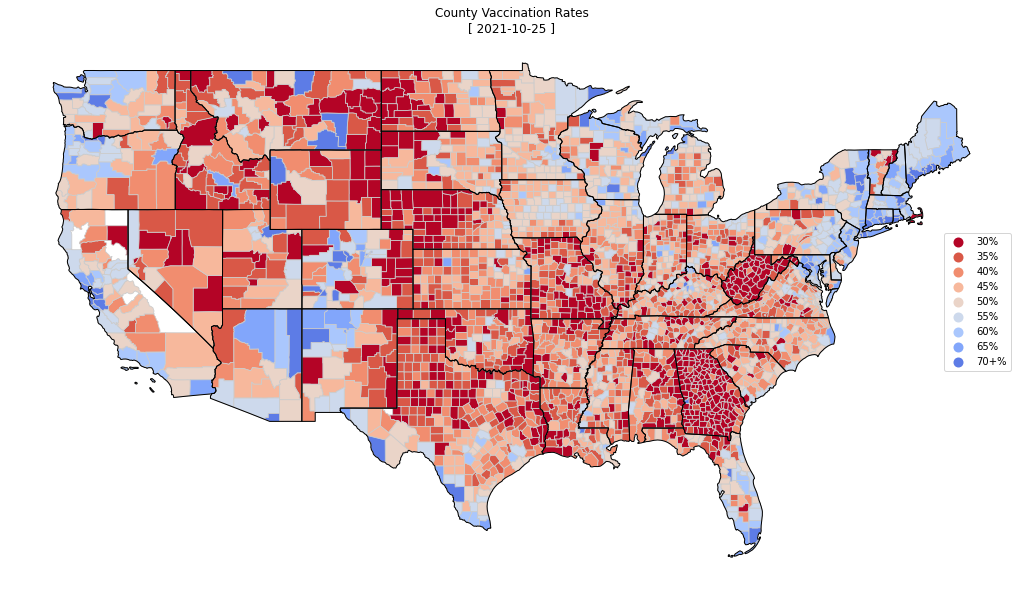

In [28]:
plot_df = geo_county_tier_df.copy()



#//*** Scale the plot to county_summary_df tiers.
#//*** Tiers outside of scope will be binned as max and min values
plot_df['tier'] = plot_df['tier'].str.replace("total_","").astype(int)


max_tier = county_summary_df['tier'].str.replace("total_","").astype(int).max()
min_tier = county_summary_df['tier'].str.replace("total_","").astype(int).min()


plot_df.loc[plot_df["tier"] < min_tier,'tier']=min_tier
plot_df.loc[plot_df["tier"] > max_tier,'tier']=max_tier

plot_df = plot_df.sort_values('tier').reset_index()

#print(plot_df['tier'].unique()[1])
#plot_df = plot_df.sort_values('tier')
plot_df['tier'] = plot_df['tier'].astype(str)
#plot_df['tier'] = plot_df['tier'].str.replace(str(min_tier),"\\< 35")

plot_df['tier'] = plot_df['tier'] + "%"
plot_df['tier'] = plot_df['tier'].str.replace("70%","70+%")
#plot_df['tier'] = plot_df['tier'].str.replace("total_5%","total_05%")


#//*** Assign column to graph
plot_column = 'tier'

#//*** Assign Categories for color palettes
plot_cats = plot_df[plot_column].unique()

#//*** Get a color Palette
item_count = len(plot_cats)
counter_list = []
counter = 0
for x in range(item_count):
    counter += 100 / item_count
    counter_list.append(counter)

vmin=0
vmax=item_count

norm = matplotlib.colors.Normalize(vmin=0, vmax=100)
#colors_palette = [matplotlib.cm.YlGn(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.YlOrBr(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Spectral(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.copper(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Accent(norm(value)) for value in counter_list]
colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list[::-1]]
#colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.OrRd(norm(value)) for value in counter_list]

#//*** Display Labels for Legend
plot_label_dict = {}



#//*** Generate Label Display Names
#for cat in plot_cats:
#    value = int(cat.replace("total_",""))
#    plot_label_dict[cat] = f"{value}"


colors = {}
counter = 0
for period in plot_cats:
    colors[period] = colors_palette[counter]
    counter+=1

labels=plot_label_dict.values()


labels=list(plot_label_dict.values())
labels=list(plot_cats)

vax_dist_df = state_daily_df[state_daily_df['Date'] == state_daily_df['Date'].max()].sort_values('Name')

ax = plot_df.plot(column='tier', cmap=ListedColormap(colors_palette),categorical=True,legend=True, linewidth=0.8,edgecolor='0.8')

#//*** Draw State Shapes over top, Set Color to transparant with Black edgecolor
ax = vax_dist_df.plot(categorical=True,legend=True, linewidth=1,edgecolor='black',color=(1,1,1,0),ax=ax)

ax.axis('off')
#plt.suptitle(f"State Vaccination Rates")
plt.title(f"County Vaccination Rates\n[ {summer_county_tier_df['Date'].max()} ]")

fig = plt.gcf()
fig.set_size_inches(20,10)


leg = ax.get_legend()


print(dir(leg.get_figure))
print(dir(leg))



leg.set_bbox_to_anchor((1,0.65,0,0))

#print(ax.legend())
#//*** Handles is taken from earlie
#plt.legend(reversed(handles),reversed(labels),loc='lower left', fontsize=12)
#plt.legend(plt.legend().legendHandles)


#outfilename=f'z_blog_natl_county_vax.jpg'
#out_blog_images.append(outfilename)
#fig.savefig(outfilename)

#out_exec_summary_images.append("z_exec_summary_binned_vax_map.jpg")
plt.show()
#plot_df['tier'] = plot_df['tier'].replace("total_","")





In [29]:
start_summary_df

,index,tier,period,Population,pop_pct,date_start,date_end,confirm_period,confirm_period_100k,confirm_deaths,death_period_100k
0,0,total_30,start,19511025,0.059963,2020-02-06,2021-06-30,1998693,10243.915940,38659,198.139257
1,0,total_35,start,17707717,0.054421,2020-02-06,2021-06-30,1939697,10953.964308,37231,210.252965
2,0,total_40,start,25596425,0.078665,2020-02-06,2021-06-30,2710649,10589.951526,49379,192.913659
3,0,total_45,start,41894717,0.128754,2020-02-06,2021-06-30,4556754,10876.679272,81405,194.308509
4,0,total_50,start,54975600,0.168955,2020-02-06,2021-06-30,5675787,10324.192915,87233,158.675849
5,0,total_55,start,62822959,0.193072,2020-02-06,2021-06-30,6094034,9700.329461,105229,167.500865
6,0,total_60,start,58282804,0.179119,2020-02-06,2021-06-30,5899468,10122.141687,110701,189.937670
7,0,total_65,start,19995896,0.061453,2020-02-06,2021-06-30,1959308,9798.550663,39032,195.200055
8,0,total_70,start,25211041,0.077480,2020-02-06,2021-06-30,2297224,9111.975979,45156,179.112001


In [30]:
#datetime.strptime(col, "%m/%d/%y").date()
start_summer_date =  datetime(2021, 7, 1).date()
type(whole_county_tier_df['Date'].iloc[0])
start_days = (start_summer_date - county_summary_df['date_start'].min()).days
summer_days = (county_summary_df['date_end'].max() - start_summer_date).days


print(start_days,summer_days)


county_analysis_dict = {
    'start_daily_100k_confirm' : start_summary_df['confirm_period_100k'].astype(int),
    'start_daily_100k_confirm_min' : start_summary_df['confirm_period_100k'].astype(int).min(),
    'start_daily_100k_confirm_max' : start_summary_df['confirm_period_100k'].astype(int).max(),
    'start_daily_mean_confirm' : start_summary_df['confirm_period'] / start_days,
    'summer_daily_mean_confirm': summer_summary_df['confirm_period'] / summer_days,
    'start_daily_mean_death' : start_summary_df['confirm_deaths'] / start_days,
    'summer_daily_mean_death': summer_summary_df['confirm_deaths'] / summer_days,
    'Population' : start_summary_df['Population'].apply(lambda x: f'{x:,}'),
    
    'pop_pct' : round(start_summary_df['pop_pct']*100,1).astype(str)+"%",
    
    'start_day_count' : start_days,
    'summer_day_count' : summer_days,
    'total_day_count' : start_days + summer_days,
    'us_total_vax' : vax_df['Series_Complete_Pop_Pct'].max(),

}

county_analysis_dict['case_change'] =  round(pd.Series(np.array(county_analysis_dict['summer_daily_mean_confirm']) / np.array(county_analysis_dict['start_daily_mean_confirm']))*100,1)
county_analysis_dict['death_change'] = round(pd.Series(np.array(county_analysis_dict['summer_daily_mean_death']) / np.array(county_analysis_dict['start_daily_mean_death']))*100,1)

county_analysis_dict['case_baseline'] = pd.Series(round( (1- county_analysis_dict['case_change'] /county_analysis_dict['case_change'][0])*100,1))
county_analysis_dict['death_baseline'] = pd.Series(round( (1- county_analysis_dict['death_change']/county_analysis_dict['death_change'][0])*100,1))

county_analysis_dict['case_change'] = county_analysis_dict['case_change'].astype(str)+'%'
county_analysis_dict['death_change'] = county_analysis_dict['death_change'].astype(str)+'%'
"""
print(start_summary_df['confirm_period'] / start_days)
print(summer_summary_df['confirm_period'] / summer_days)

print( pd.Series(np.array(county_analysis_dict['summer_daily_mean_confirm']) / np.array(county_analysis_dict['start_daily_mean_confirm'])))

print(start_summary_df['confirm_deaths'] / start_days)
print(summer_summary_df['confirm_deaths'] / summer_days)
print( pd.Series(np.array(county_analysis_dict['summer_daily_mean_death']) / np.array(county_analysis_dict['start_daily_mean_death'])))
"""
manage_df['county_analysis_dict'] = "Summary Stats for Display for the blog post"
county_analysis_dict

511 116


{'start_daily_100k_confirm': 0    10243
 1    10953
 2    10589
 3    10876
 4    10324
 5     9700
 6    10122
 7     9798
 8     9111
 Name: confirm_period_100k, dtype: int32,
 'start_daily_100k_confirm_min': 9111,
 'start_daily_100k_confirm_max': 10953,
 'start_daily_mean_confirm': 0     3911.336595
 1     3795.884540
 2     5304.596869
 3     8917.326810
 4    11107.215264
 5    11925.702544
 6    11544.947162
 7     3834.262231
 8     4495.545988
 Name: confirm_period, dtype: float64,
 'summer_daily_mean_confirm': 9      8065.715517
 10     7928.396552
 11    10821.310345
 12    14553.827586
 13    18759.586207
 14    17195.956897
 15    13517.474138
 16     3501.750000
 17     5026.465517
 Name: confirm_period, dtype: float64,
 'start_daily_mean_death': 0     75.653620
 1     72.859100
 2     96.632094
 3    159.305284
 4    170.710372
 5    205.927593
 6    216.636008
 7     76.383562
 8     88.367906
 Name: confirm_deaths, dtype: float64,
 'summer_daily_mean_death': 9     116.7

In [31]:
county_analysis_dict

{'start_daily_100k_confirm': 0    10243
 1    10953
 2    10589
 3    10876
 4    10324
 5     9700
 6    10122
 7     9798
 8     9111
 Name: confirm_period_100k, dtype: int32,
 'start_daily_100k_confirm_min': 9111,
 'start_daily_100k_confirm_max': 10953,
 'start_daily_mean_confirm': 0     3911.336595
 1     3795.884540
 2     5304.596869
 3     8917.326810
 4    11107.215264
 5    11925.702544
 6    11544.947162
 7     3834.262231
 8     4495.545988
 Name: confirm_period, dtype: float64,
 'summer_daily_mean_confirm': 9      8065.715517
 10     7928.396552
 11    10821.310345
 12    14553.827586
 13    18759.586207
 14    17195.956897
 15    13517.474138
 16     3501.750000
 17     5026.465517
 Name: confirm_period, dtype: float64,
 'start_daily_mean_death': 0     75.653620
 1     72.859100
 2     96.632094
 3    159.305284
 4    170.710372
 5    205.927593
 6    216.636008
 7     76.383562
 8     88.367906
 Name: confirm_deaths, dtype: float64,
 'summer_daily_mean_death': 9     116.7

In [32]:
state_hosp_tiers_df

,population,Date,tot_death,tot_confirm,New_Cases,New_Deaths,case_7_day_avg,case_avg_100k,death_7_day_avg,death_avg_100k,loc,FIPS,tier,total_beds,beds_used,covid_beds_used,icu_total,icu_used,covid_icu,covid_beds_adult,covid_beds_kids,case_scaled_100k,death_scaled_100k
16,9061156,2020-02-07,0,0,0,0,0.000000,0.0,0.000000,0.0,AL,"[1, 16, 54, 56]",total_40,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,9061156,2020-02-08,0,0,0,0,0.000000,0.0,0.000000,0.0,AL,"[1, 16, 54, 56]",total_40,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,9061156,2020-02-09,0,0,0,0,0.000000,0.0,0.000000,0.0,AL,"[1, 16, 54, 56]",total_40,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,9061156,2020-02-10,0,0,0,0,0.000000,0.0,0.000000,0.0,AL,"[1, 16, 54, 56]",total_40,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,9061156,2020-02-11,0,0,0,0,0.000000,0.0,0.000000,0.0,AL,"[1, 16, 54, 56]",total_40,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3853,6592849,2021-10-21,13026,715474,2957,20,2832.000000,42.955633,16.142857,0.244854,CT,"[9, 23, 44, 50]",total_70,15434.0,12528.0,606.0,1621.0,0.572948753948006,181.0,596.0,10.0,42.955633,0.244854
3854,6592849,2021-10-22,13050,716926,3031,30,2728.142857,41.380333,16.428571,0.249188,CT,"[9, 23, 44, 50]",total_70,15504.0,12529.0,617.0,1628.0,0.473183777364258,158.0,607.0,10.0,41.380333,0.249188
3855,6592849,2021-10-23,13057,717764,2290,31,2703.857143,41.011968,17.571429,0.266523,CT,"[9, 23, 44, 50]",total_70,15449.0,12132.0,605.0,1617.0,0.5273319485611321,166.0,594.0,11.0,41.011968,0.266523
3856,6592849,2021-10-24,13057,718034,1108,7,2700.714286,40.964298,18.000000,0.273023,CT,"[9, 23, 44, 50]",total_70,15346.0,11835.0,610.0,1627.0,0.511349017897782,174.0,599.0,11.0,40.964298,0.273023


In [33]:
vax_df = pd.read_csv(vaccine_data_filename)

#//*** Filter Columns to get just the Completed Values
cols = ['Date','Location']
filter_val = ['FedLTC','Unk','Janssen','Pfizer','Moderna','Fed_LTC']
for col in vax_df.columns:
    if 'Complete' in col or 'Dose1' in col:
        skipVal = False
        for val in filter_val:
            if val in col:
                skipVal = True
                continue
        if skipVal:
            continue
        cols.append(col)

#//*** Keep Relevant Data
vax_df = vax_df[cols]

vax_df = vax_df[vax_df["Location"] == 'US' ]
#vax_df['Date'] = 
vax_df['Date'] = pd.to_datetime(vax_df['Date'])

vax_df = vax_df.sort_values('Date')

out_stats

out_stats['total_vaccinated_count'] = format (vax_df.iloc[-1]["Series_Complete_Yes"],',d')
out_stats['total_vaccinated_percent'] = f"{vax_df.iloc[-1]['Series_Complete_Pop_Pct']}%"
out_stats['first_dose_count'] = format (vax_df.iloc[-1]["Administered_Dose1_Recip"],',d')
out_stats['first_dose_percent'] = f"{vax_df.iloc[-1]['Administered_Dose1_Pop_Pct']}%"

manage_df['vax_df'] = "United States Total Vaccine Levels [2020-12-13 - Present]"
vax_df

,Date,Location,Administered_Dose1_Recip,Administered_Dose1_Pop_Pct,Administered_Dose1_Recip_12Plus,Administered_Dose1_Recip_12PlusPop_Pct,Administered_Dose1_Recip_18Plus,Administered_Dose1_Recip_18PlusPop_Pct,Administered_Dose1_Recip_65Plus,Administered_Dose1_Recip_65PlusPop_Pct,Series_Complete_Yes,Series_Complete_Pop_Pct,Series_Complete_12Plus,Series_Complete_12PlusPop_Pct,Series_Complete_18Plus,Series_Complete_18PlusPop_Pct,Series_Complete_65Plus,Series_Complete_65PlusPop_Pct
20253,2020-12-13,US,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
20214,2020-12-14,US,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
20158,2020-12-15,US,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
20129,2020-12-16,US,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
20068,2020-12-17,US,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,2021-10-22,US,219900525,66.2,219666287,77.5,204788212,79.3,52572844,96.1,190179553,57.3,190046408,67.0,177683586,68.8,46264299,84.6
222,2021-10-23,US,220145796,66.3,219911449,77.6,205012732,79.4,52627847,96.2,190402262,57.4,190269066,67.1,177883133,68.9,46294318,84.6
186,2021-10-24,US,220351217,66.4,220116796,77.6,205201180,79.5,52678218,96.3,190578704,57.4,190445478,67.2,178039457,68.9,46318073,84.7
87,2021-10-25,US,220519217,66.4,220284773,77.7,205357459,79.5,52729596,96.4,190699790,57.4,190566551,67.2,178145538,69.0,46334975,84.7


- [Graph Interactive: U.S. Vaccinations](#graph_us_vaccinations_by_state)


<a id="graph_us_vaccinations_by_state"></a> 
# Graph: U.S. Vaccinations #

- [Graph: Total U.S. Vaccinations Full and Partial (Line Graph Interactive)](#graph_total_us_vaccination_full_and_partial)


<a id="graph_total_us_vaccination_full_and_partial"></a> 
# Graph: Total U.S. Vaccinations Full and Partial (Line Graph Interactive) #

- [Graph: List States by Highest Current Death rates (Bar Plot)](#graph_list_states_highest_death_rates)


<a id="graph_list_states_highest_death_rates"></a> 
# Graph: List States by Highest Current Death rates (Bar Plot) #

- [Graph: US Total New Deaths Per Day (Line Plot)](#graph_US_total_new_deaths_per_day)


<a id="graph_US_total_new_deaths_per_day"></a> 
# Graph: US Total New Deaths Per Day (Line Plot) #

- [Graph: List States by Highest New Cases (Bar Plot)](#graph_list_states_highest_death_rates)


<a id="graph_list_states_highest_new_cases"></a> 
# Graph: List States by Highest Current Death rates (Bar Plot) #

- [Graph: Table of States with Highest Total COVID Counts (Table Plot)](#graph_list_states_highest_total_cases)


<a id="graph_list_states_highest_total_cases"></a> 
# Graph: Table of States with Highest Total COVID Counts (Table Plot) #

- [Graph: U.S. Total COVID Cases Trend (Line Plot)](#graph_us_total_covid_cases_trend)


<a id="graph_us_total_covid_cases_trend"></a> 
# Graph: U.S. Total COVID Cases Trend (Line Plot) #

In [34]:
"""#//*********************************
#//*********************************
#//*** RENDER HISTORICAL GIF
#//*********************************
#//*********************************
rebuild_all_images = False

if 'copy_files' not in out_controls.keys():
    out_controls['copy_files'] = {}

out_controls['copy_files']['infographic_cases'] = []

#//*** Only Render Animated GIF if not using Cached values...ie during an update.
if True:

    #//********************************************
    #//*** Build Output Filepath
    #//********************************************
    filepath = os.getcwd()
    filepath = filepath.replace("\\","/")
    filepath = f"{filepath}/project/infographic_confirm/"

    files_jpg = []
    gif_files = []
    #//********************************************


    plot_df = attrib_confirm_df.copy()

    fontsize=15

    dates = all_dates[100:]
    #dates = all_dates[-30:]

    first=True

    file_counter = 0
    print("Working...")
    for date in dates:

        file_counter += 1

        save_filename = f"{filepath}confirm_hist_{file_counter}.jpg"
        if rebuild_all_images == False:
            #//*** Check If File already Exists, If yes....Skip it.
            if os.path.exists(save_filename):
                #print(f"Skipping: {save_filename}")
                out_controls['copy_files']['infographic_cases'].append(save_filename)
                continue

                
        fig, ax = plt.subplots()

        fig.set_size_inches(10,5)
        fig = plt.gcf()
        ax.axis('off')

        # Create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap=plt.viridis(), norm=plt.Normalize(vmin=0, vmax=100))

        # empty array for the data range
        sm._A = []
        


        cbar = fig.colorbar(sm,shrink=.7)

        #plt.title("Cumulative COVID Prevalence",fontsize=display_size)
        #fig.text(.78, .2, 'Cumulative Cases (per 100k)', va='center' ,fontsize=display_size/2)
        plot_df.plot(column=f'{date}_scaled_100k', ax=ax,linewidth=0.8,edgecolor='.8')
        plt.title(f"COVID-19 Prevalence\nNew Cases per 100,000 Population (7-Day Average)",fontsize=fontsize)
        plt.text(-120,25,date,fontsize=fontsize)
        plt.viridis()

        out_controls['copy_files']['infographic_cases'].append(save_filename)
        print(save_filename)
        plt.savefig(save_filename,pil_kwargs={'quality': 70})

        plt.close()
        
    
    

    print("Done...")
"""
print()

- [Graph: Infographic Visualization](#infographic_visualization)


<a id="infographic_visualization"></a> 
# Graph: Infographic Visualization #

In [29]:
import numpy as np
import pandas as pd
from datetime import datetime
county_daily_df_filename = "z_county_daily_df.csv.zip"
whole_county_tier_df_filename = "z_whole_county_tier_df.csv.zip"
whole_county_tier_df =pd.read_pickle(whole_county_tier_df_filename)
start_summer_date =  datetime(2021, 7, 1).date()
    
out_master = {}

#county_daily_df = pd.read_pickle(county_daily_df_filename)

#county_daily_df = county_daily_df[county_daily_df['Population'] > 0]

#county_vax_df


start_avg_daily_county_tier_df = whole_county_tier_df[whole_county_tier_df['Date'] < start_summer_date ]

td = {
    #//*** Columns to work with. These are in order, and order matters since some fields are derived from others,
    'base_cols' : ["Date","tier","Population","tot_confirm","tot_deaths","New_Confirm","New_Deaths","case_100k_avg",'case_100k_avg_daily',"death_100k_avg","death_100k_avg_daily"],
    #'base_cols' : ["Date","tier","Population","tot_confirm","tot_deaths","New_Confirm","New_Deaths"],
    'out_cols' : [], 
   
    'tiers' : list(whole_county_tier_df['tier'].unique()),
    
    'dates' : [],
    
    'days' : [],
}

#//*** Initialize Lists. Keep Everything in a dictionary. Maybe it'll be faster than shuffling around dataframes
for col in td['base_cols']:
    td[col] = []

td["relative_confirm_100k"] = []
td["relative_death_100k"] = []

start_period_date = start_avg_daily_county_tier_df['Date'].min()

#td['dates'] = list(start_avg_daily_county_tier_df['Date'].unique())
td['days'] = range(1,len(td['dates'])+1)

for date in start_avg_daily_county_tier_df['Date'].unique():
    if date >= start_summer_date:
        break
    loop_df = start_avg_daily_county_tier_df[start_avg_daily_county_tier_df['Date'] == date]
    

    
    days = (date - start_period_date).days + 1
    
    loop_relative_confirm = []
    loop_relative_deaths = []
    
    #//*** Convert Date to String for JSON
    date = date.strftime("%Y/%m/%d")
    
    for tier in td['tiers']:
        #print(date,days,tier)
        for col in td['base_cols']:
            if col == "Date":
                td[col].append(date)
                continue
            if col =='tier':
                td[col].append(tier)
                continue
            if col == "Population":
                pop = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(pop)
                continue
            if col == "tot_confirm":
                tot_confirm = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(tot_confirm)
                continue
            if col == "tot_deaths":
                tot_deaths = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(tot_deaths)
                continue
                
            if col == "New_Confirm":
                new_confirm = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(new_confirm)
                continue

            if col == "case_100k_avg":
                case_100k_avg = int(tot_confirm / (pop / 100000))
                td[col].append(case_100k_avg)
                loop_relative_confirm.append(case_100k_avg)
                continue
                
            if col == "case_100k_avg_daily":
                case_100k_avg_daily = round(case_100k_avg / days,2)
                td[col].append(case_100k_avg_daily)

            if col == "tot_deaths":
                tot_deaths = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(tot_deaths)
                continue
                
            if col == "New_Deaths":
                new_deaths = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(new_deaths)
                continue  

            if col == "death_100k_avg":
                death_100k_avg = loop_df[loop_df['tier'] == tier][col].values[0]
                td[col].append(round(death_100k_avg,4))
                loop_relative_deaths.append(death_100k_avg)
                continue
                
            if col == "death_100k_avg_daily":
                death_100k_avg_daily = round(death_100k_avg / days,2)
                td[col].append(death_100k_avg_daily)
                continue

#    print(date,tier,pop,tot_confirm,case_100k_avg,days,case_100k_avg_daily,loop_relative_confirm)                
    if loop_relative_confirm[0] == 0:
        loop_relative_confirm = np.full(len(loop_relative_confirm),0)
    else:
        loop_relative_confirm = np.array(loop_relative_confirm) /  loop_relative_confirm[0]
        
    loop_relative_confirm = (loop_relative_confirm *100).round(2).astype(str)
    
    for x in loop_relative_confirm:
        td["relative_confirm_100k"].append(x+"%")
    
    if loop_relative_deaths[0] == 0:
        loop_relative_deaths = np.full(len(loop_relative_deaths),0)
    else:
        loop_relative_deaths = np.array(loop_relative_deaths) /  loop_relative_deaths[0] 
    
    loop_relative_deaths = (loop_relative_deaths *100).round(2).astype(str)
    
    for x in loop_relative_deaths:
        td["relative_death_100k"].append(x+"%")
    
for x in range(len(td['Date'])):
    print(x,td['Date'][x],td['tier'][x],td['New_Confirm'][x],td['tier'][x],td['case_100k_avg'][x],td["relative_confirm_100k"][x])

import json
#//*** Build Infographic Left.json
out = {}

for index in range(len(td['Date'])):
    
    loop_dict = {}
    
    for col in td['base_cols']:
        
        loop_dict[col] = td[col][index]
    
    loop_dict["relative_confirm_100k"] = td["relative_confirm_100k"][index]
    loop_dict["relative_death_100k"] =td["relative_death_100k"][index]
    
    loop_date = td["Date"][index]
    if  loop_date not in out.keys():
        out[loop_date] = {}
    loop_tier = td["tier"][index]
    #//*** Each Date is a key, each tier is a separate dictionary
    out[loop_date][loop_tier] = loop_dict



if 'build_json' not in out_master.keys():
    out_master['build_json'] = {}
    
out_master['build_json']['infographic_left'] = {
    'filename' : 'infographic_left.js',
    'path' : '/wk09_10/',
    'data' : f"var infographic_left = {json.dumps(out)}"
    #'data' : json.dumps(out)
}
#for col in td['base_cols']:
#    print(col,len(td[col]))
#print("relative_confirm_100k",len(td["relative_confirm_100k"]),"relative_death_100k",len(td["relative_death_100k"]))  
last_date = td['Date'][-1]


0 2020/02/06 total_30 0 total_30 0 0%
1 2020/02/06 total_35 0 total_35 0 0%
2 2020/02/06 total_40 0 total_40 0 0%
3 2020/02/06 total_45 0 total_45 0 0%
4 2020/02/06 total_50 0 total_50 0 0%
5 2020/02/06 total_55 0 total_55 0 0%
6 2020/02/06 total_60 1 total_60 0 0%
7 2020/02/06 total_65 0 total_65 0 0%
8 2020/02/06 total_70 0 total_70 0 0%
9 2020/02/07 total_30 0 total_30 0 0%
10 2020/02/07 total_35 0 total_35 0 0%
11 2020/02/07 total_40 0 total_40 0 0%
12 2020/02/07 total_45 0 total_45 0 0%
13 2020/02/07 total_50 0 total_50 0 0%
14 2020/02/07 total_55 0 total_55 0 0%
15 2020/02/07 total_60 1 total_60 0 0%
16 2020/02/07 total_65 0 total_65 0 0%
17 2020/02/07 total_70 0 total_70 0 0%
18 2020/02/08 total_30 0 total_30 0 0%
19 2020/02/08 total_35 0 total_35 0 0%
20 2020/02/08 total_40 0 total_40 0 0%
21 2020/02/08 total_45 0 total_45 0 0%
22 2020/02/08 total_50 0 total_50 0 0%
23 2020/02/08 total_55 0 total_55 0 0%
24 2020/02/08 total_60 0 total_60 0 0%
25 2020/02/08 total_65 0 total_65 0

319 2020/03/12 total_50 39 total_50 0 0%
320 2020/03/12 total_55 101 total_55 0 0%
321 2020/03/12 total_60 180 total_60 0 0%
322 2020/03/12 total_65 111 total_65 1 0%
323 2020/03/12 total_70 278 total_70 2 0%
324 2020/03/13 total_30 22 total_30 0 0%
325 2020/03/13 total_35 6 total_35 0 0%
326 2020/03/13 total_40 17 total_40 0 0%
327 2020/03/13 total_45 41 total_45 0 0%
328 2020/03/13 total_50 67 total_50 0 0%
329 2020/03/13 total_55 126 total_55 0 0%
330 2020/03/13 total_60 237 total_60 0 0%
331 2020/03/13 total_65 138 total_65 1 0%
332 2020/03/13 total_70 305 total_70 2 0%
333 2020/03/14 total_30 42 total_30 0 0%
334 2020/03/14 total_35 23 total_35 0 0%
335 2020/03/14 total_40 23 total_40 0 0%
336 2020/03/14 total_45 47 total_45 0 0%
337 2020/03/14 total_50 113 total_50 0 0%
338 2020/03/14 total_55 201 total_55 0 0%
339 2020/03/14 total_60 327 total_60 1 0%
340 2020/03/14 total_65 144 total_65 2 0%
341 2020/03/14 total_70 366 total_70 3 0%
342 2020/03/15 total_30 57 total_30 0 0%
343 

661 2020/04/19 total_50 4233 total_50 102 90.27%
662 2020/04/19 total_55 10954 total_55 251 222.12%
663 2020/04/19 total_60 13097 total_60 315 278.76%
664 2020/04/19 total_65 8181 total_65 579 512.39%
665 2020/04/19 total_70 7429 total_70 548 484.96%
666 2020/04/20 total_30 2027 total_30 119 100.0%
667 2020/04/20 total_35 1176 total_35 77 64.71%
668 2020/04/20 total_40 2809 total_40 92 77.31%
669 2020/04/20 total_45 3734 total_45 125 105.04%
670 2020/04/20 total_50 3977 total_50 105 88.24%
671 2020/04/20 total_55 10343 total_55 260 218.49%
672 2020/04/20 total_60 14667 total_60 329 276.47%
673 2020/04/20 total_65 8921 total_65 604 507.56%
674 2020/04/20 total_70 8231 total_70 566 475.63%
675 2020/04/21 total_30 1799 total_30 122 100.0%
676 2020/04/21 total_35 1264 total_35 81 66.39%
677 2020/04/21 total_40 1858 total_40 96 78.69%
678 2020/04/21 total_45 4043 total_45 129 105.74%
679 2020/04/21 total_50 4174 total_50 109 89.34%
680 2020/04/21 total_55 10696 total_55 268 219.67%
681 2020

965 2020/05/23 total_40 2410 total_40 252 90.97%
966 2020/05/23 total_45 4225 total_45 288 103.97%
967 2020/05/23 total_50 6070 total_50 277 100.0%
968 2020/05/23 total_55 10935 total_55 569 205.42%
969 2020/05/23 total_60 9852 total_60 667 240.79%
970 2020/05/23 total_65 3557 total_65 1043 376.53%
971 2020/05/23 total_70 3413 total_70 882 318.41%
972 2020/05/24 total_30 1896 total_30 283 100.0%
973 2020/05/24 total_35 1631 total_35 261 92.23%
974 2020/05/24 total_40 2213 total_40 256 90.46%
975 2020/05/24 total_45 3985 total_45 293 103.53%
976 2020/05/24 total_50 5412 total_50 282 99.65%
977 2020/05/24 total_55 10124 total_55 577 203.89%
978 2020/05/24 total_60 8725 total_60 674 238.16%
979 2020/05/24 total_65 3161 total_65 1050 371.02%
980 2020/05/24 total_70 3472 total_70 889 314.13%
981 2020/05/25 total_30 2114 total_30 288 100.0%
982 2020/05/25 total_35 1801 total_35 266 92.36%
983 2020/05/25 total_40 2389 total_40 262 90.97%
984 2020/05/25 total_45 3787 total_45 297 103.12%
985 2

1269 2020/06/26 total_30 4531 total_30 514 100.0%
1270 2020/06/26 total_35 3982 total_35 502 97.67%
1271 2020/06/26 total_40 6451 total_40 484 94.16%
1272 2020/06/26 total_45 14260 total_45 578 112.45%
1273 2020/06/26 total_50 15412 total_50 520 101.17%
1274 2020/06/26 total_55 16288 total_55 829 161.28%
1275 2020/06/26 total_60 16253 total_60 960 186.77%
1276 2020/06/26 total_65 2090 total_65 1245 242.22%
1277 2020/06/26 total_70 5317 total_70 1087 211.48%
1278 2020/06/27 total_30 4316 total_30 524 100.0%
1279 2020/06/27 total_35 3409 total_35 510 97.33%
1280 2020/06/27 total_40 6066 total_40 494 94.27%
1281 2020/06/27 total_45 14612 total_45 594 113.36%
1282 2020/06/27 total_50 17145 total_50 536 102.29%
1283 2020/06/27 total_55 16762 total_55 841 160.5%
1284 2020/06/27 total_60 16182 total_60 973 185.69%
1285 2020/06/27 total_65 2713 total_65 1251 238.74%
1286 2020/06/27 total_70 5466 total_70 1097 209.35%
1287 2020/06/28 total_30 3537 total_30 532 100.0%
1288 2020/06/28 total_35 28

1583 2020/07/30 total_70 9850 total_70 1668 137.85%
1584 2020/07/31 total_30 10837 total_30 1237 100.0%
1585 2020/07/31 total_35 9005 total_35 1171 94.66%
1586 2020/07/31 total_40 13140 total_40 1183 95.63%
1587 2020/07/31 total_45 20257 total_45 1341 108.41%
1588 2020/07/31 total_50 23967 total_50 1211 97.9%
1589 2020/07/31 total_55 22164 total_55 1369 110.67%
1590 2020/07/31 total_60 21228 total_60 1592 128.7%
1591 2020/07/31 total_65 4680 total_65 1548 125.14%
1592 2020/07/31 total_70 8979 total_70 1685 136.22%
1593 2020/08/01 total_30 9876 total_30 1261 100.0%
1594 2020/08/01 total_35 8099 total_35 1192 94.53%
1595 2020/08/01 total_40 11617 total_40 1203 95.4%
1596 2020/08/01 total_45 18895 total_45 1362 108.01%
1597 2020/08/01 total_50 21472 total_50 1228 97.38%
1598 2020/08/01 total_55 21270 total_55 1384 109.75%
1599 2020/08/01 total_60 18983 total_60 1606 127.36%
1600 2020/08/01 total_65 4944 total_65 1559 123.63%
1601 2020/08/01 total_70 9258 total_70 1704 135.13%
1602 2020/08

1896 2020/09/03 total_60 11035 total_60 1983 102.48%
1897 2020/09/03 total_65 3053 total_65 1843 95.25%
1898 2020/09/03 total_70 4616 total_70 2096 108.32%
1899 2020/09/04 total_30 8213 total_30 1955 100.0%
1900 2020/09/04 total_35 7275 total_35 1835 93.86%
1901 2020/09/04 total_40 9901 total_40 1796 91.87%
1902 2020/09/04 total_45 14248 total_45 1872 95.75%
1903 2020/09/04 total_50 17606 total_50 1752 89.62%
1904 2020/09/04 total_55 15607 total_55 1791 91.61%
1905 2020/09/04 total_60 11859 total_60 1995 102.05%
1906 2020/09/04 total_65 2804 total_65 1849 94.58%
1907 2020/09/04 total_70 4801 total_70 2106 107.72%
1908 2020/09/05 total_30 7434 total_30 1974 100.0%
1909 2020/09/05 total_35 6826 total_35 1852 93.82%
1910 2020/09/05 total_40 9739 total_40 1814 91.89%
1911 2020/09/05 total_45 13139 total_45 1886 95.54%
1912 2020/09/05 total_50 18028 total_50 1767 89.51%
1913 2020/09/05 total_55 16949 total_55 1803 91.34%
1914 2020/09/05 total_60 11589 total_60 2003 101.47%
1915 2020/09/05 t

2229 2020/10/10 total_60 12524 total_60 2319 90.44%
2230 2020/10/10 total_65 4800 total_65 2143 83.58%
2231 2020/10/10 total_70 3926 total_70 2378 92.75%
2232 2020/10/11 total_30 7195 total_30 2579 100.0%
2233 2020/10/11 total_35 8051 total_35 2538 98.41%
2234 2020/10/11 total_40 11000 total_40 2428 94.15%
2235 2020/10/11 total_45 14879 total_45 2403 93.18%
2236 2020/10/11 total_50 18475 total_50 2250 87.24%
2237 2020/10/11 total_55 19886 total_55 2267 87.9%
2238 2020/10/11 total_60 11383 total_60 2329 90.31%
2239 2020/10/11 total_65 4840 total_65 2154 83.52%
2240 2020/10/11 total_70 4179 total_70 2388 92.59%
2241 2020/10/12 total_30 5435 total_30 2592 100.0%
2242 2020/10/12 total_35 6237 total_35 2555 98.57%
2243 2020/10/12 total_40 8934 total_40 2443 94.25%
2244 2020/10/12 total_45 13087 total_45 2419 93.33%
2245 2020/10/12 total_50 15539 total_50 2263 87.31%
2246 2020/10/12 total_55 16788 total_55 2279 87.92%
2247 2020/10/12 total_60 10997 total_60 2338 90.2%
2248 2020/10/12 total_6

2522 2020/11/12 total_40 27851 total_40 3509 98.48%
2523 2020/11/12 total_45 42469 total_45 3385 95.0%
2524 2020/11/12 total_50 55581 total_50 3172 89.03%
2525 2020/11/12 total_55 65745 total_55 3180 89.25%
2526 2020/11/12 total_60 43016 total_60 2956 82.96%
2527 2020/11/12 total_65 17891 total_65 2956 82.96%
2528 2020/11/12 total_70 13039 total_70 2852 80.04%
2529 2020/11/13 total_30 18171 total_30 3614 100.0%
2530 2020/11/13 total_35 24486 total_35 3846 106.42%
2531 2020/11/13 total_40 31346 total_40 3581 99.09%
2532 2020/11/13 total_45 47975 total_45 3448 95.41%
2533 2020/11/13 total_50 58841 total_50 3226 89.26%
2534 2020/11/13 total_55 72508 total_55 3237 89.57%
2535 2020/11/13 total_60 43847 total_60 2994 82.84%
2536 2020/11/13 total_65 19245 total_65 3011 83.31%
2537 2020/11/13 total_70 14781 total_70 2885 79.83%
2538 2020/11/14 total_30 20150 total_30 3667 100.0%
2539 2020/11/14 total_35 25171 total_35 3913 106.71%
2540 2020/11/14 total_40 33316 total_40 3639 99.24%
2541 2020/1

2843 2020/12/17 total_70 28077 total_70 4288 79.61%
2844 2020/12/18 total_30 29984 total_30 5465 100.0%
2845 2020/12/18 total_35 29774 total_35 6262 114.58%
2846 2020/12/18 total_40 40466 total_40 5853 107.1%
2847 2020/12/18 total_45 70643 total_45 5799 106.11%
2848 2020/12/18 total_50 85959 total_50 5360 98.08%
2849 2020/12/18 total_55 78419 total_55 5185 94.88%
2850 2020/12/18 total_60 87938 total_60 4943 90.45%
2851 2020/12/18 total_65 23242 total_65 4828 88.34%
2852 2020/12/18 total_70 27822 total_70 4345 79.51%
2853 2020/12/19 total_30 26549 total_30 5523 100.0%
2854 2020/12/19 total_35 26097 total_35 6324 114.5%
2855 2020/12/19 total_40 36908 total_40 5913 107.06%
2856 2020/12/19 total_45 65998 total_45 5870 106.28%
2857 2020/12/19 total_50 83784 total_50 5429 98.3%
2858 2020/12/19 total_55 72123 total_55 5238 94.84%
2859 2020/12/19 total_60 81721 total_60 5008 90.68%
2860 2020/12/19 total_65 21223 total_65 4872 88.21%
2861 2020/12/19 total_70 26757 total_70 4394 79.56%
2862 2020

3157 2021/01/21 total_65 21638 total_65 6785 88.31%
3158 2021/01/21 total_70 26328 total_70 6255 81.41%
3159 2021/01/22 total_30 25937 total_30 7751 100.0%
3160 2021/01/22 total_35 21855 total_35 8504 109.71%
3161 2021/01/22 total_40 31585 total_40 8164 105.33%
3162 2021/01/22 total_45 53558 total_45 8198 105.77%
3163 2021/01/22 total_50 63481 total_50 7674 99.01%
3164 2021/01/22 total_55 63704 total_55 7060 91.09%
3165 2021/01/22 total_60 65734 total_60 7362 94.98%
3166 2021/01/22 total_65 21223 total_65 6840 88.25%
3167 2021/01/22 total_70 26068 total_70 6306 81.36%
3168 2021/01/23 total_30 26651 total_30 7819 100.0%
3169 2021/01/23 total_35 19552 total_35 8558 109.45%
3170 2021/01/23 total_40 29793 total_40 8218 105.1%
3171 2021/01/23 total_45 49545 total_45 8254 105.56%
3172 2021/01/23 total_50 59913 total_50 7724 98.79%
3173 2021/01/23 total_55 60644 total_55 7107 90.89%
3174 2021/01/23 total_60 65999 total_60 7419 94.88%
3175 2021/01/23 total_65 20572 total_65 6888 88.09%
3176 20

3453 2021/02/23 total_60 22562 total_60 8432 95.33%
3454 2021/02/23 total_65 10122 total_65 7909 89.42%
3455 2021/02/23 total_70 11444 total_70 7344 83.03%
3456 2021/02/24 total_30 10100 total_30 8872 100.0%
3457 2021/02/24 total_35 7796 total_35 9578 107.96%
3458 2021/02/24 total_40 12269 total_40 9250 104.26%
3459 2021/02/24 total_45 18107 total_45 9267 104.45%
3460 2021/02/24 total_50 23555 total_50 8721 98.3%
3461 2021/02/24 total_55 24677 total_55 8009 90.27%
3462 2021/02/24 total_60 26626 total_60 8457 95.32%
3463 2021/02/24 total_65 10406 total_65 7935 89.44%
3464 2021/02/24 total_70 12146 total_70 7369 83.06%
3465 2021/02/25 total_30 10370 total_30 8898 100.0%
3466 2021/02/25 total_35 8217 total_35 9601 107.9%
3467 2021/02/25 total_40 11981 total_40 9273 104.21%
3468 2021/02/25 total_45 18071 total_45 9289 104.39%
3469 2021/02/25 total_50 25199 total_50 8744 98.27%
3470 2021/02/25 total_55 26449 total_55 8031 90.26%
3471 2021/02/25 total_60 28250 total_60 8481 95.31%
3472 2021/

3797 2021/04/02 total_70 13985 total_70 8211 86.3%
3798 2021/04/03 total_30 4968 total_30 9527 100.0%
3799 2021/04/03 total_35 4183 total_35 10187 106.93%
3800 2021/04/03 total_40 6069 total_40 9821 103.09%
3801 2021/04/03 total_45 16155 total_45 9915 104.07%
3802 2021/04/03 total_50 20416 total_50 9371 98.36%
3803 2021/04/03 total_55 29089 total_55 8740 91.74%
3804 2021/04/03 total_60 26286 total_60 9217 96.75%
3805 2021/04/03 total_65 11319 total_65 8888 93.29%
3806 2021/04/03 total_70 12615 total_70 8234 86.43%
3807 2021/04/04 total_30 3615 total_30 9534 100.0%
3808 2021/04/04 total_35 2631 total_35 10191 106.89%
3809 2021/04/04 total_40 3704 total_40 9825 103.05%
3810 2021/04/04 total_45 10677 total_45 9920 104.05%
3811 2021/04/04 total_50 14642 total_50 9380 98.38%
3812 2021/04/04 total_55 22664 total_55 8754 91.82%
3813 2021/04/04 total_60 20912 total_60 9231 96.82%
3814 2021/04/04 total_65 9135 total_65 8908 93.43%
3815 2021/04/04 total_70 10379 total_70 8252 86.55%
3816 2021/04

4117 2021/05/08 total_50 14441 total_50 9992 100.64%
4118 2021/05/08 total_55 16951 total_55 9412 94.8%
4119 2021/05/08 total_60 13889 total_60 9867 99.39%
4120 2021/05/08 total_65 4370 total_65 9590 96.6%
4121 2021/05/08 total_70 5543 total_70 8867 89.31%
4122 2021/05/09 total_30 2974 total_30 9934 100.0%
4123 2021/05/09 total_35 2205 total_35 10624 106.95%
4124 2021/05/09 total_40 3228 total_40 10274 103.42%
4125 2021/05/09 total_45 6562 total_45 10534 106.04%
4126 2021/05/09 total_50 9928 total_50 9999 100.65%
4127 2021/05/09 total_55 12619 total_55 9420 94.83%
4128 2021/05/09 total_60 10137 total_60 9874 99.4%
4129 2021/05/09 total_65 3269 total_65 9596 96.6%
4130 2021/05/09 total_70 4657 total_70 8875 89.34%
4131 2021/05/10 total_30 2351 total_30 9940 100.0%
4132 2021/05/10 total_35 2632 total_35 10635 106.99%
4133 2021/05/10 total_40 3646 total_40 10283 103.45%
4134 2021/05/10 total_45 8158 total_45 10549 106.13%
4135 2021/05/10 total_50 10377 total_50 10011 100.71%
4136 2021/05/

4424 2021/06/11 total_55 7863 total_55 9648 95.02%
4425 2021/06/11 total_60 6055 total_60 10071 99.18%
4426 2021/06/11 total_65 1545 total_65 9759 96.11%
4427 2021/06/11 total_70 3506 total_70 9069 89.31%
4428 2021/06/12 total_30 2176 total_30 10157 100.0%
4429 2021/06/12 total_35 2788 total_35 10861 106.93%
4430 2021/06/12 total_40 2666 total_40 10505 103.43%
4431 2021/06/12 total_45 4529 total_45 10794 106.27%
4432 2021/06/12 total_50 6984 total_50 10253 100.95%
4433 2021/06/12 total_55 7442 total_55 9652 95.03%
4434 2021/06/12 total_60 5372 total_60 10072 99.16%
4435 2021/06/12 total_65 1274 total_65 9761 96.1%
4436 2021/06/12 total_70 3390 total_70 9071 89.31%
4437 2021/06/13 total_30 1082 total_30 10159 100.0%
4438 2021/06/13 total_35 891 total_35 10862 106.92%
4439 2021/06/13 total_40 792 total_40 10507 103.43%
4440 2021/06/13 total_45 1879 total_45 10796 106.27%
4441 2021/06/13 total_50 1969 total_50 10254 100.94%
4442 2021/06/13 total_55 3280 total_55 9654 95.03%
4443 2021/06/1

In [ ]:

start_summer_date-timedelta(days=1)

In [43]:
from datetime import timedelta


last_counts_dict = {}

for group in whole_county_tier_df[whole_county_tier_df['Date'] == (start_summer_date-timedelta(days=1))].groupby('tier'):
    last_counts_dict[group[0]] = {
        'tot_confirm' : group[1]['tot_confirm'].values[0],
        'tot_deaths' : group[1]['tot_deaths'].values[0],
    }
print(last_counts_dict)


import numpy as np
import pandas as pd
from datetime import datetime
county_daily_df_filename = "z_county_daily_df.csv.zip"
whole_county_tier_df_filename = "z_whole_county_tier_df.csv.zip"
whole_county_tier_df =pd.read_pickle(whole_county_tier_df_filename)
start_summer_date =  datetime(2021, 7, 1).date()

#county_daily_df = pd.read_pickle(county_daily_df_filename)

#county_daily_df = county_daily_df[county_daily_df['Population'] > 0]

#county_vax_df


start_avg_daily_county_tier_df = whole_county_tier_df[whole_county_tier_df['Date'] >= start_summer_date ]

td = {
    #//*** Columns to work with. These are in order, and order matters since some fields are derived from others,
    'base_cols' : ["Date","tier","Population","tot_confirm","tot_deaths","New_Confirm","New_Deaths","case_100k_avg",'case_100k_avg_daily',"death_100k_avg","death_100k_avg_daily"],
    #'base_cols' : ["Date","tier","Population","tot_confirm","tot_deaths","New_Confirm","New_Deaths"],
    'out_cols' : [], 
   
    'tiers' : list(whole_county_tier_df['tier'].unique()),
    
    'dates' : [],
    
    'days' : [],
}

#//*** Initialize Lists. Keep Everything in a dictionary. Maybe it'll be faster than shuffling around dataframes
for col in td['base_cols']:
    td[col] = []

td["relative_confirm_100k"] = []
td["relative_death_100k"] = []

start_period_date = start_avg_daily_county_tier_df['Date'].min()

#td['dates'] = list(start_avg_daily_county_tier_df['Date'].unique())
td['days'] = range(1,len(td['dates'])+1)

for date in start_avg_daily_county_tier_df['Date'].unique():

    loop_df = start_avg_daily_county_tier_df[start_avg_daily_county_tier_df['Date'] == date]
    

    
    days = (date - start_period_date).days + 1
    
    loop_relative_confirm = []
    loop_relative_deaths = []
    
    #//*** Convert Date to String for JSON
    date = date.strftime("%Y/%m/%d")
    
    for tier in td['tiers']:
        #print(date,days,tier)
        for col in td['base_cols']:
            if col == "Date":
                td[col].append(date)
                continue
            if col =='tier':
                td[col].append(tier)
                continue
            if col == "Population":
                pop = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(pop)
                continue
            if col == "tot_confirm":
                tot_confirm = loop_df[loop_df['tier'] == tier][col].values[0]
                
                tot_confirm =  tot_confirm - last_counts_dict[tier]['tot_confirm']
                
                td[col].append(int(tot_confirm))
                continue
            if col == "tot_deaths":
                tot_deaths = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(tot_deaths)
                continue
                
            if col == "New_Confirm":
                new_confirm = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(new_confirm)
                continue

            if col == "case_100k_avg":
                case_100k_avg = int(tot_confirm / (pop / 100000))
                td[col].append(case_100k_avg)
                loop_relative_confirm.append(case_100k_avg)
                continue
                
            if col == "case_100k_avg_daily":
                case_100k_avg_daily = round(case_100k_avg / days,2)
                td[col].append(case_100k_avg_daily)

            if col == "tot_deaths":
                tot_deaths = int(loop_df[loop_df['tier'] == tier][col].values[0])
                
                tot_deaths =  tot_tot_deathsconfirm - last_counts_dict[tier]['tot_deaths']
                
                td[col].append(int(tot_deaths))
                continue
                
            if col == "New_Deaths":
                new_deaths = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(new_deaths)
                continue  

            if col == "death_100k_avg":
                death_100k_avg = loop_df[loop_df['tier'] == tier][col].values[0]
                td[col].append(round(death_100k_avg,4))
                loop_relative_deaths.append(death_100k_avg)
                continue
                
            if col == "death_100k_avg_daily":
                death_100k_avg_daily = round(death_100k_avg / days,2)
                td[col].append(death_100k_avg_daily)
                continue

#    print(date,tier,pop,tot_confirm,case_100k_avg,days,case_100k_avg_daily,loop_relative_confirm)                
    if loop_relative_confirm[0] == 0:
        loop_relative_confirm = np.full(len(loop_relative_confirm),0)
    else:
        loop_relative_confirm = np.array(loop_relative_confirm) /  loop_relative_confirm[0]
        
    loop_relative_confirm = (loop_relative_confirm *100).round(2).astype(str)
    
    for x in loop_relative_confirm:
        td["relative_confirm_100k"].append(x+"%")
    
    if loop_relative_deaths[0] == 0:
        loop_relative_deaths = np.full(len(loop_relative_deaths),0)
    else:
        loop_relative_deaths = np.array(loop_relative_deaths) /  loop_relative_deaths[0] 
    
    loop_relative_deaths = (loop_relative_deaths *100).round(2).astype(str)
    
    for x in loop_relative_deaths:
        td["relative_death_100k"].append(x+"%")
    
for x in range(len(td['Date'])):
    print(x,td['Date'][x],td['tier'][x],td['tot_confirm'][x],td['tier'][x],td['case_100k_avg_daily'][x],td["relative_confirm_100k"][x])

import json
#//*** Build Infographic Left.json
out = {}

for index in range(len(td['Date'])):
    
    loop_dict = {}
    
    for col in td['base_cols']:
        
        loop_dict[col] = td[col][index]
    
    loop_dict["relative_confirm_100k"] = td["relative_confirm_100k"][index]
    loop_dict["relative_death_100k"] =td["relative_death_100k"][index]
    
    loop_date = td["Date"][index]
    if  loop_date not in out.keys():
        out[loop_date] = {}
    loop_tier = td["tier"][index]
    #//*** Each Date is a key, each tier is a separate dictionary
    out[loop_date][loop_tier] = loop_dict
    



if 'build_json' not in out_master.keys():
    out_master['build_json'] = {}
    
out_master['build_json']['infographic_right'] = {
    'filename' : 'infographic_right.js',
    'path' : '/wk09_10/',
    'data' : f"var infographic_right = {json.dumps(out)}"
    #'data' : json.dumps(out)
}
#for col in td['base_cols']:
#    print(col,len(td[col]))
#print("relative_confirm_100k",len(td["relative_confirm_100k"]),"relative_death_100k",len(td["relative_death_100k"]))  


{'total_30': {'tot_confirm': 1998693, 'tot_deaths': 38659}, 'total_35': {'tot_confirm': 1939697, 'tot_deaths': 37231}, 'total_40': {'tot_confirm': 2710649, 'tot_deaths': 49379}, 'total_45': {'tot_confirm': 4556755, 'tot_deaths': 81405}, 'total_50': {'tot_confirm': 5675787, 'tot_deaths': 87233}, 'total_55': {'tot_confirm': 6094038, 'tot_deaths': 105230}, 'total_60': {'tot_confirm': 5899472, 'tot_deaths': 110701}, 'total_65': {'tot_confirm': 1959308, 'tot_deaths': 39032}, 'total_70': {'tot_confirm': 2297227, 'tot_deaths': 45156}}
0 2021/07/01 total_30 1157 total_30 5.0 100.0%
1 2021/07/01 total_35 1171 total_35 6.0 120.0%
2 2021/07/01 total_40 1608 total_40 6.0 120.0%
3 2021/07/01 total_45 2451 total_45 5.0 100.0%
4 2021/07/01 total_50 2286 total_50 4.0 80.0%
5 2021/07/01 total_55 2159 total_55 3.0 60.0%
6 2021/07/01 total_60 1750 total_60 3.0 60.0%
7 2021/07/01 total_65 468 total_65 2.0 40.0%
8 2021/07/01 total_70 704 total_70 2.0 40.0%
9 2021/07/02 total_30 2399 total_30 6.0 100.0%
10 

316 2021/08/05 total_35 126748 total_35 19.86 110.17%
317 2021/08/05 total_40 185205 total_40 20.08 111.4%
318 2021/08/05 total_45 248849 total_45 16.47 91.37%
319 2021/08/05 total_50 332055 total_50 16.78 93.07%
320 2021/08/05 total_55 272210 total_55 12.03 66.72%
321 2021/08/05 total_60 274995 total_60 13.08 72.57%
322 2021/08/05 total_65 52566 total_65 7.28 40.37%
323 2021/08/05 total_70 115922 total_70 12.75 70.72%
324 2021/08/06 total_30 137930 total_30 19.08 100.0%
325 2021/08/06 total_35 137781 total_35 21.03 110.2%
326 2021/08/06 total_40 202602 total_40 21.38 112.04%
327 2021/08/06 total_45 271857 total_45 17.51 91.78%
328 2021/08/06 total_50 388073 total_50 19.05 99.86%
329 2021/08/06 total_55 319946 total_55 13.76 72.1%
330 2021/08/06 total_60 320809 total_60 14.86 77.9%
331 2021/08/06 total_65 64220 total_65 8.68 45.47%
332 2021/08/06 total_70 140459 total_70 15.05 78.9%
333 2021/08/07 total_30 140139 total_30 18.89 100.0%
334 2021/08/07 total_35 140427 total_35 20.87 110.4

634 2021/09/09 total_50 1281489 total_50 32.83 79.29%
635 2021/09/09 total_55 1117436 total_55 25.04 60.48%
636 2021/09/09 total_60 961802 total_60 23.24 56.12%
637 2021/09/09 total_65 214016 total_65 15.07 36.39%
638 2021/09/09 total_70 380908 total_70 21.27 51.36%
639 2021/09/10 total_30 591302 total_30 42.08 100.0%
640 2021/09/10 total_35 553304 total_35 43.39 103.1%
641 2021/09/10 total_40 768524 total_40 41.69 99.08%
642 2021/09/10 total_45 997092 total_45 33.04 78.51%
643 2021/09/10 total_50 1339550 total_50 33.83 80.4%
644 2021/09/10 total_55 1166540 total_55 25.78 61.25%
645 2021/09/10 total_60 1001228 total_60 23.85 56.67%
646 2021/09/10 total_65 220528 total_65 15.31 36.37%
647 2021/09/10 total_70 396214 total_70 21.82 51.85%
648 2021/09/11 total_30 596844 total_30 41.9 100.0%
649 2021/09/11 total_35 558458 total_35 43.19 103.07%
650 2021/09/11 total_40 774977 total_40 41.47 98.95%
651 2021/09/11 total_45 1005320 total_45 32.86 78.42%
652 2021/09/11 total_50 1348300 total_50 

962 2021/10/15 total_70 555304 total_70 20.58 47.85%
963 2021/10/16 total_30 900288 total_30 42.72 100.0%
964 2021/10/16 total_35 877705 total_35 45.89 107.41%
965 2021/10/16 total_40 1198014 total_40 43.33 101.43%
966 2021/10/16 total_45 1595272 total_45 35.25 82.51%
967 2021/10/16 total_50 2065704 total_50 34.79 81.43%
968 2021/10/16 total_55 1878789 total_55 27.69 64.8%
969 2021/10/16 total_60 1481889 total_60 23.54 55.09%
970 2021/10/16 total_65 374564 total_65 17.34 40.59%
971 2021/10/16 total_70 556538 total_70 20.44 47.83%
972 2021/10/17 total_30 901587 total_30 42.39 100.0%
973 2021/10/17 total_35 878736 total_35 45.52 107.4%
974 2021/10/17 total_40 1199038 total_40 42.97 101.39%
975 2021/10/17 total_45 1596702 total_45 34.96 82.49%
976 2021/10/17 total_50 2068512 total_50 34.51 81.43%
977 2021/10/17 total_55 1882396 total_55 27.49 64.85%
978 2021/10/17 total_60 1485816 total_60 23.39 55.17%
979 2021/10/17 total_65 376125 total_65 17.26 40.71%
980 2021/10/17 total_70 557208 tot

In [44]:
import os
#//****************************************************************************************
#//*** Copy the HTML/Javascript & Animated GIFs o the Website Production Folder
#//****************************************************************************************
directory_path = os.getcwd()

directory_path = directory_path.replace("\\","/")

#//*** Remove two sublevels to get to github root
directory_path = "".join(f"{x}/" for x in directory_path.split("/")[:-2])

#//*** Add in Fixed Relative path
directory_path += "/kstoneburner.github.io/DSC640/"

#//*** Handle out_master fileops
for top_key,top_values in out_master.items():
    if top_key == 'build_json':
        for key,json_dict in top_values.items():
            outpath = directory_path
            if 'path' in json_dict.keys():
                outpath = outpath + json_dict['path']
            
            outpath = outpath + json_dict['filename']
            outpath = outpath.replace("//","/")
            
            print("Writing File:",outpath)
                
            #//*** Write the updated text to file
            with open(outpath , "w") as f:
                f.write(json_dict['data'])
            
            
            




Writing File: C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_left.js
Writing File: C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_right.js


In [36]:
manage_df

{'county_vax_df': 'County Vaccination Data [ 2020-12-13 - Present ]',
 'state_daily_df': 'State Population Vaccination Case Death [2020-12-14 - Present]',
 'confirm_df': 'Johns Hopkins Case Data stored in Date Columns [20/01/22 - Present]',
 'death_df': 'Johns Hopkins Death Data stored in Date Columns [20/01/22 - Present]',
 'state_case_death': 'State Level Cases and Deaths Only [2020/01/30 - Present]',
 'attrib_confirm_df': 'Case Data stored Column Wise for Bokeh Slider plots includes New Cases, Cases 100k, Scaled Cases, [2020/01/29 - Present]',
 'attrib_death_df': 'Death Data stored Column Wise for Bokeh Slider plots includes New Deaths, Deaths 100k, Scaled Cases, [2020/01/29 - Present]',
 'hospital_df': 'Statewide Hospitalization Numbers [2020-01-01 - Present]',
 'vax_tier_state_df': 'State Tiers: Vaccinated, Confirm, Deaths [2020-12-28 - Present]',
 'state_hospital_tiers_df': 'Tiers Statewide Hospitalization Case and Death [2020-02-07 - Present]',
 'county_tier_df': 'Tiers County V

In [37]:
whole_county_tier_df

,Date,FIPS,Admin2,Province_State,Combined_Key,Population,tot_confirm,tot_deaths,New_Confirm,New_Deaths,case_7_day_avg,death_7_day_avg,case_100k_avg,death_100k_avg,case_scaled_100k,death_scaled_100k,tier
15,2020-02-06,"[8109, 48241, 1117, 40129, 32027, 21203, 47153...",Bibb,Alabama,"Bibb, Alabama, US",19511025,0,0,0,0,0.000000,0.000000,0.0,0.0,0.0,0.0,total_30
16,2020-02-07,"[8109, 48241, 1117, 40129, 32027, 21203, 47153...",Bibb,Alabama,"Bibb, Alabama, US",19511025,0,0,0,0,0.000000,0.000000,0.0,0.0,0.0,0.0,total_30
17,2020-02-08,"[8109, 48241, 1117, 40129, 32027, 21203, 47153...",Bibb,Alabama,"Bibb, Alabama, US",19511025,0,0,0,0,0.000000,0.000000,0.0,0.0,0.0,0.0,total_30
18,2020-02-09,"[8109, 48241, 1117, 40129, 32027, 21203, 47153...",Bibb,Alabama,"Bibb, Alabama, US",19511025,0,0,0,0,0.000000,0.000000,0.0,0.0,0.0,0.0,total_30
19,2020-02-10,"[8109, 48241, 1117, 40129, 32027, 21203, 47153...",Bibb,Alabama,"Bibb, Alabama, US",19511025,0,0,0,0,0.000000,0.000000,0.0,0.0,0.0,0.0,total_30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
638,2021-10-21,"[6013, 48479, 36059, 6001, 30035, 55007, 53055...",Apache,Arizona,"Apache, Arizona, US",25211041,2869998,47317,6809,89,6829.428571,82.142857,27.089038,0.325821,27.089038,0.325821,total_70
639,2021-10-22,"[6013, 48479, 36059, 6001, 30035, 55007, 53055...",Apache,Arizona,"Apache, Arizona, US",25211041,2875075,47362,8513,86,6610.714286,83.857143,26.221505,0.332621,26.221505,0.332621,total_70
640,2021-10-23,"[6013, 48479, 36059, 6001, 30035, 55007, 53055...",Apache,Arizona,"Apache, Arizona, US",25211041,2876307,47370,6309,53,6440.857143,87.857143,25.547764,0.348487,25.547764,0.348487,total_70
641,2021-10-24,"[6013, 48479, 36059, 6001, 30035, 55007, 53055...",Apache,Arizona,"Apache, Arizona, US",25211041,2876862,47373,1787,11,6424.142857,84.428571,25.481466,0.334887,25.481466,0.334887,total_70


In [38]:

#//****************************************************************************************
#//*** Copy the HTML/Javascript & Animated GIFs o the Website Production Folder
#//****************************************************************************************
directory_path = os.getcwd()

directory_path = directory_path.replace("\\","/")

#//*** Remove two sublevels to get to github root
directory_path = "".join(f"{x}/" for x in directory_path.split("/")[:-2])

#//*** Add in Fixed Relative path
directory_path += "/kstoneburner.github.io/DSC640/"


for filename,html in out_plot.items():
    
    
    #//*** write raw HTML to output folder
    with open(f"{directory_path}{filename}.raw" , "w") as f:
        print(f"Writing File:{directory_path}{filename}.raw")
        f.write(html)

for filename in out_images:
    shutil.copyfile(filename, f"{directory_path}{filename}")


In [39]:
#//****************************************************************************************
#//*** Update the HTML Template, by inserting Graph code into the template placeholders
#//*** Keeps things smooth(ish)
#//****************************************************************************************

import os
#//****************************************************************************************
#//*** Copy the HTML/Javascript & Animated GIFs o the Website Production Folder
#//****************************************************************************************
directory_path = os.getcwd()

directory_path = directory_path.replace("\\","/")

#//*** Remove two sublevels to get to github root
directory_path = "".join(f"{x}/" for x in directory_path.split("/")[:-2])

#//*** Add in Fixed Relative path
directory_path += "/kstoneburner.github.io/DSC640/"


input_template_filename = "covid_dash_v1.template.html"
output_html_filename = input_template_filename.replace(".template","")


#//*** Load the Template
with open(f"{directory_path}{input_template_filename}" , "r") as f:
    template_text = f.read()

#//******************************************************
#//*** Replace template values with out_plot keys
#//******************************************************
#//*** Replace Each Value in Replace_vals
for find in out_plot.keys():

    replace_filename = f"{find}.raw"
    
    with open(f"{directory_path}{replace_filename}" , "r") as f:
        find = f"$${find}$$"
        #//*** Replace the find val (placeholder) with the HTML file
        template_text = template_text.replace(find,f.read())
        
#//*** Replace Bokeh Network calls with local calls

template_text = template_text.replace("https://cdn.bokeh.org/bokeh/release/bokeh-2.4.0.min.js","bokeh/bokeh-2.4.0.min.js")
template_text = template_text.replace("https://cdn.bokeh.org/bokeh/release/bokeh-gl-2.4.0.min.js","bokeh/bokeh-gl-2.4.0.min.js")
template_text = template_text.replace("https://cdn.bokeh.org/bokeh/release/bokeh-widgets-2.4.0.min.js","bokeh/bokeh-widgets-2.4.0.min.js")
template_text = template_text.replace("https://cdn.bokeh.org/bokeh/release/bokeh-tables-2.4.0.min.js","bokeh/bokeh-tables-2.4.0.min.js")
template_text = template_text.replace("https://cdn.bokeh.org/bokeh/release/bokeh-mathjax-2.4.0.min.js","bokeh/bokeh-mathjax-2.4.0.min.js")
        
    
for find,replace in out_stats.items():
    template_text = template_text.replace(f"$${find}$$",replace)

#//*** Write the updated text to file
with open(f"{directory_path}{output_html_filename}" , "w") as f:
    f.write(template_text)


In [40]:
summer_overview_state_dict
out_exec_summary ={}

#//*** Build the State Summary Table
state_summary ={}
#//*** Display Intervals 40%,45%...etc
state_summary['levels'] = [f'{x.replace("total_","")}%' for x in list(summer_overview_state_dict.keys())]
state_summary['states'] =[]
state_summary['pct'] = []
for key,value in summer_overview_state_dict.items():
    state_summary['states'].append(", ".join(value['states']))
    state_summary['pct'].append(f"{round(value['pop_pct']*100,1)}%")
out_table=""
out_table+="<table>"
out_table+="<thead>"
for val in state_summary['levels']:
    out_table += f"<td>{val}</td>"
out_table+="</thead>"
out_table+="<tr>"
for val in state_summary['states']:
    out_table += f"<td>{val}</td>"
out_table+="</tr>"
#out_table+="<tr>"
#for val in state_summary['pct']:
#    out_table += f"<td>{val}\r\nU.S. Pop</td>"
#out_table+="</tr>"
out_table+="</table>"

out_exec_summary['summary_table'] = out_table
summer_overview_state_dict

{'total_40': {'population': 9061156,
  'pop_pct': 0.027694839022798394,
  'date_start': Timestamp('2021-01-07 00:00:00'),
  'date_end': Timestamp('2021-10-25 00:00:00'),
  'confirm_period': 796555,
  'confirm_start': 678573,
  'confirm_end': 1475128,
  'confirm_period_100k': 8790.876131036703,
  'confirm_deaths': 15672,
  'death_period_100k': 172.9580640704122,
  'vax_complete': 3941295,
  'vax_complete_100k': 43496.60242026514,
  'vax_partial': 4688302,
  'vax_partial_100k': 51740.66090463513,
  'states': ['Alabama', 'Idaho', 'West Virginia', 'Wyoming']},
 'total_45': {'population': 50826738,
  'pop_pct': 0.15534864723264338,
  'date_start': Timestamp('2021-01-07 00:00:00'),
  'date_end': Timestamp('2021-10-25 00:00:00'),
  'confirm_period': 4250149,
  'confirm_start': 3900796,
  'confirm_end': 8150945,
  'confirm_period_100k': 8362.033778362877,
  'confirm_deaths': 70446,
  'death_period_100k': 138.60027767274775,
  'vax_complete': 24515387,
  'vax_complete_100k': 48233.24880695668,


In [41]:



deaths_low = 10000
confirm_low = 10000
deaths_high = 0
confirm_high = 0
for key,value in summer_overview_state_dict.items():
    if summer_overview_state_dict[key]['death_period_100k'] > deaths_high:
        deaths_high = summer_overview_state_dict[key]['death_period_100k']

    if summer_overview_state_dict[key]['death_period_100k'] < deaths_low:
        deaths_low = summer_overview_state_dict[key]['death_period_100k']
        
    if summer_overview_state_dict[key]['confirm_period_100k'] > confirm_high:
        confirm_high = summer_overview_state_dict[key]['confirm_period_100k']

    if summer_overview_state_dict[key]['confirm_period_100k'] < confirm_low:
        confirm_low = summer_overview_state_dict[key]['confirm_period_100k']


#print(deaths_high,deaths_low,confirm_high,confirm_low)
fewer_death_percent = f"{round((1 - deaths_low / deaths_high)*100,1)}%"
fewer_cases_percent = f"{round((1 - confirm_low / confirm_high)*100,1)}%"
#print(fewer_death_percent, fewer_cases_percent)

exec_summary_variable_update = {
    "confirm_low" : str(int(confirm_low)),
    "confirm_high" : str(int(confirm_high)),
    "deaths_low" : str(int(deaths_low)),
    "deaths_high" : str(int(deaths_high)),
    "fewer_death_percent" : fewer_death_percent,
    "fewer_cases_percent" : fewer_cases_percent
}



In [42]:
input_template_filename = "covid_vaccine_results.template.html"
output_html_filename = input_template_filename.replace(".template","")


#//*** Load the Template
with open(f"{directory_path}{input_template_filename}" , "r") as f:
    template_text = f.read()
    
    
    #//*** Update 
out_exec_summary_images

for filename in out_exec_summary_images:
    shutil.copyfile(filename, f"{directory_path}{filename}")

for find, replace in out_exec_summary.items():
    template_text = template_text.replace(f"$${find}$$",replace)

for find, replace in exec_summary_variable_update.items():

    template_text = template_text.replace(f"$${find}$$",replace)
    
#//*** Write the updated text to file
with open(f"{directory_path}{output_html_filename}" , "w") as f:
    f.write(template_text)

## Build Blog Post: COVID Vaccine Comparison Page ##
- [ Blog Graphs ](#build_blog_graphs)

In [43]:
#//**** Build slideshow HTML
replace_dict = {}

slide_images = []
for img in out_blog_images:
    if "z_blog_vax_county" in img:
        slide_images.append(img)

i=0

out_html = '<div class="slideshow-container">'
slide_template_html = ""
slide_template_html += f'<div class="mySlides fade"><div class="numbertext">$$index$$ / {len(slide_images)}</div><img src="$$filename$$" style="width:100%"></div>'

for img in slide_images:
        i+=1
        out_html += slide_template_html.replace("$$index$$",f"{i}").replace("$$filename$$",img) + "\n"

out_html += '<a class="prev" onclick="plusSlides(-1)">&#10094;</a>\n'
out_html += '<a class="next" onclick="plusSlides(1)">&#10095;</a>\n'
out_html += "</div>\n"
out_html += "<br/>\n"


out_html += '<div style="text-align:center">\n'

i=0
for img in slide_images:
        i+=1
        out_html += f'<span class="dot" onclick="currentSlide({i})"></span>\n'
out_html += '</div>\n'

replace_dict['blog_slide_show'] = out_html
        
replace_dict['blog_case_baseline_max'] = f"{county_analysis_dict['case_baseline'].max()}"
replace_dict['blog_death_baseline_max'] = f"{county_analysis_dict['death_baseline'].max()}"
replace_dict['total_pandemic_days'] = f"{(county_daily_df['Date'].max() - county_daily_df['Date'].min()).days}"




NameError: name 'out_blog_images' is not defined

In [ ]:
#//*** Build HTML TAB
county_analysis_dict

tiers = pd.Series(start_summary_df['tier'].unique()).str.replace("total_","").astype(int)
tiers.iloc[0] = tiers.iloc[1] -1
tiers = tiers.astype(str)
tiers.iloc[0] = "< " + tiers.iloc[0]
tiers.iloc[-1] = tiers.iloc[-1] + "+"
tiers = list(tiers + "%")
tiers

In [ ]:
county_analysis_dict

out_blog_images


input_template_filename = "covid_vaccine_comparison.template.html"
output_html_filename = input_template_filename.replace(".template","")
images_list = out_blog_images

#//*** Load the Template
with open(f"{directory_path}{input_template_filename}" , "r") as f:
    template_text = f.read()
    
    
for filename in images_list:
    shutil.copyfile(filename, f"{directory_path}{filename}")

for find, replace in replace_dict.items():
    template_text = template_text.replace(f"$${find}$$",replace)

#//*** Write the updated text to file
with open(f"{directory_path}{output_html_filename}" , "w") as f:
    f.write(template_text)

In [ ]:
plot_df